In [1]:
import arcpy
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def listar_capas_gdb(gdb_path, tipo='RasterDataset'):
    """
    Lista todas las capas de una Geodatabase.

    Parameters:
    -----------
    gdb_path : str
        Ruta a la Geodatabase (.gdb)
    tipo : str
        Tipo de dataset a listar:
        - 'RasterDataset' para raster layers
        - 'FeatureClass' para vectores

    Returns:
    --------
    list
        Lista con los nombres de las capas encontradas.
    """
    arcpy.env.workspace = gdb_path
    if tipo == 'RasterDataset':
        capas = arcpy.ListRasters()
    elif tipo == 'FeatureClass':
        capas = arcpy.ListFeatureClasses()
    else:
        raise ValueError("Tipo debe ser 'RasterDataset' o 'FeatureClass'")
    
    return capas


In [3]:

def exportar_rasters(df, y, gdb_path, base_layer, prefix="modelo"):
    """
    Exporta todas las variables de df, y y_pred como RasterDataset en la GDB.

    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame con las variables X.
    y : np.ndarray
        Vector con la variable dependiente real (esperanzavidadept).
    y_pred : np.ndarray
        Vector con las predicciones del modelo.
    gdb_path : str
        Ruta a la geodatabase de salida.
    base_layer : str
        Nombre de la capa base para referencia espacial.
    prefix : str
        Prefijo para nombrar las salidas.
    """
    arcpy.env.workspace = gdb_path
    arcpy.env.overwriteOutput = True
    base_raster = arcpy.Raster(f"{gdb_path}\\{base_layer}")

    # Shape y extent base
    nrows, ncols = base_raster.height, base_raster.width
    extent = base_raster.extent
    sr = base_raster.spatialReference
    cellsize = base_raster.meanCellWidth

    # Máscara válida (donde tomamos valores en df y y_pred)
    base_array = arcpy.RasterToNumPyArray(base_raster, nodata_to_value=-9999).astype('float32')
    base_array[base_array == -9999] = np.nan
    valid_mask = ~np.isnan(base_array)

    # Función auxiliar para reconstruir array 2D
    def vector_to_raster(array_1d):
        raster_array = np.full(base_array.shape, np.nan, dtype='float32')
        raster_array[valid_mask] = array_1d
        return raster_array

    # Exportar variables X
    for var in df.columns:
        print(f"Exportando: {var}")
        raster_data = vector_to_raster(df[var].values)
        output_raster = os.path.join(gdb_path, f"{prefix}_{var}")
        arcpy.NumPyArrayToRaster(raster_data, lower_left_corner=arcpy.Point(extent.XMin, extent.YMin),
                                 x_cell_size=cellsize, y_cell_size=cellsize, value_to_nodata=np.nan).save(output_raster)

    # Exportar y real
    print(f"Exportando: {prefix}_Y_real")
    y_real_raster = vector_to_raster(y)
    arcpy.NumPyArrayToRaster(y_real_raster, lower_left_corner=arcpy.Point(extent.XMin, extent.YMin),
                             x_cell_size=cellsize, y_cell_size=cellsize, value_to_nodata=np.nan).save(
                             os.path.join(gdb_path, f"{prefix}_Y_real"))

    

    print("✅ Exportación finalizada.")


In [4]:
def alinear_y_extraer_rasters_final(gdb_path, raster_layers, aoi_vector, base_layer):
    arcpy.env.workspace = gdb_path

    # Raster base
    base_raster = arcpy.Raster(f"{gdb_path}\\{base_layer}")
    cell_size = base_raster.meanCellWidth

    # Forzar SnapRaster
    arcpy.env.snapRaster = base_raster

    # Base array y máscara válida
    base_array = arcpy.RasterToNumPyArray(base_raster, nodata_to_value=-9999).astype('float32')
    base_array[base_array == -9999] = np.nan
    valid_mask = ~np.isnan(base_array)

    n_valid_pixels = np.count_nonzero(valid_mask)

    data = {}

    for layer in raster_layers:
        print(f"Procesando: {layer}")

        raster = arcpy.Raster(f"{gdb_path}\\{layer}")
        clipped_raster = arcpy.sa.ExtractByMask(raster, aoi_vector)

        # Reproyección si SR diferente
        if clipped_raster.spatialReference.name != base_raster.spatialReference.name:
            print(f"  ⚠️ Reproyectando {layer}")
            temp_project = f"in_memory\\temp_proj_{layer}"
            arcpy.management.ProjectRaster(clipped_raster, temp_project, base_raster.spatialReference, "BILINEAR", cell_size)
            clipped_raster = arcpy.Raster(temp_project)

        # Resample si cellsize difiere
        if not math.isclose(clipped_raster.meanCellWidth, cell_size, rel_tol=1e-6):
            print(f"  ⚠️ Resampleando {layer}")
            temp_resample = f"in_memory\\temp_resample_{layer}"
            arcpy.management.Resample(clipped_raster, temp_resample, cell_size, "BILINEAR")
            clipped_raster = arcpy.Raster(temp_resample)
            arcpy.management.Delete(temp_resample)

        # Convertir a array
        raster_array = arcpy.RasterToNumPyArray(clipped_raster, nodata_to_value=-9999).astype('float32')

        # Limpiar proyectado temporal si existió
        if 'temp_project' in locals():
            arcpy.management.Delete(temp_project)
            del temp_project

        # Forzar raster_array al shape exacto del base (sin ajustar valid_mask)
        min_rows = min(raster_array.shape[0], base_array.shape[0])
        min_cols = min(raster_array.shape[1], base_array.shape[1])
        raster_array = raster_array[:min_rows, :min_cols]

        # Si el raster era más pequeño que el base, rellenar con NaN hasta completar shape base
        if raster_array.shape != base_array.shape:
            print(f"  ⚠️ Rellenando borde en {layer} para igualar shape {raster_array.shape} -> {base_array.shape}")
            padded_array = np.full(base_array.shape, np.nan, dtype='float32')
            padded_array[:raster_array.shape[0], :raster_array.shape[1]] = raster_array
            raster_array = padded_array

        # Nodata a NaN
        raster_array[raster_array == -9999] = np.nan

        # Extraer solo los valores válidos de la máscara base (tamaño fijo)
        data[layer] = raster_array[valid_mask]

        # Verificación final de longitudes:
        if data[layer].size != n_valid_pixels:
            raise ValueError(f"❌ Error en {layer}: {data[layer].size} != {n_valid_pixels} válidos del base")

    # DataFrame final garantizado con shapes iguales
    df = pd.DataFrame(data)
    return df


In [5]:
def cargar_variable_y(gdb_path, capa_y, aoi_vector, base_layer):
    """
    Carga la capa 'esperanzavidadept' como variable Y, alineada al raster base.

    Parameters:
    -----------
    gdb_path : str
        Ruta a la geodatabase.
    capa_y : str
        Nombre de la capa Y (ej: 'esperanzavidadept').
    aoi_vector : str
        Path al featureclass/shapefile del AOI.
    base_layer : str
        Raster base de referencia.

    Returns:
    --------
    np.ndarray
        Vector Y con valores válidos alineados al raster base.
    """
    arcpy.env.workspace = gdb_path

    # Raster base
    base_raster = arcpy.Raster(f"{gdb_path}\\{base_layer}")
    cell_size = base_raster.meanCellWidth

    # Forzar SnapRaster
    arcpy.env.snapRaster = base_raster

    # Base mask
    base_array = arcpy.RasterToNumPyArray(base_raster, nodata_to_value=-9999).astype('float32')
    base_array[base_array == -9999] = np.nan
    valid_mask = ~np.isnan(base_array)

    # Cargar capa Y
    raster_y = arcpy.Raster(f"{gdb_path}\\{capa_y}")

    # Clip con AOI
    clipped_y = arcpy.sa.ExtractByMask(raster_y, aoi_vector)

    # Reproyección si es necesario
    if clipped_y.spatialReference.name != base_raster.spatialReference.name:
        print(f"  ⚠️ Reproyectando {capa_y} a {base_raster.spatialReference.name}")
        temp_project = f"in_memory\\temp_proj_y"
        arcpy.management.ProjectRaster(clipped_y, temp_project, base_raster.spatialReference, "BILINEAR", cell_size)
        clipped_y = arcpy.Raster(temp_project)

    # Resample si cellsize difiere
    if not math.isclose(clipped_y.meanCellWidth, cell_size, rel_tol=1e-6):
        print(f"  ⚠️ Resampleando {capa_y}")
        temp_resample = f"in_memory\\temp_resample_y"
        arcpy.management.Resample(clipped_y, temp_resample, cell_size, "BILINEAR")
        clipped_y = arcpy.Raster(temp_resample)
        arcpy.management.Delete(temp_resample)

    # Convertir a array
    y_array = arcpy.RasterToNumPyArray(clipped_y, nodata_to_value=-9999).astype('float32')

    # Limpiar proyectado temporal si hubo
    if 'temp_project' in locals():
        arcpy.management.Delete(temp_project)
        del temp_project

    # Forzar shape al base (relleno con NaN si es necesario)
    min_rows = min(y_array.shape[0], base_array.shape[0])
    min_cols = min(y_array.shape[1], base_array.shape[1])
    y_array = y_array[:min_rows, :min_cols]

    if y_array.shape != base_array.shape:
        print(f"igualar shape {y_array.shape} -> {base_array.shape}")
        padded_array = np.full(base_array.shape, np.nan, dtype='float32')
        padded_array[:y_array.shape[0], :y_array.shape[1]] = y_array
        y_array = padded_array

    # Nodata a NaN
    y_array[y_array == -9999] = np.nan

    # Extraer valores válidos según la máscara base
    y_vector = y_array[valid_mask]

    print(f"Variable Y cargada: {y_vector.shape[0]} píxeles válidos")

    return y_vector


In [6]:
gdb_path = r"C:\Users\Sebastian\Documents\ArcGIS\Projects\CIDENAL\RasterIncial.gdb"
raster_layers = listar_capas_gdb(gdb_path, tipo='RasterDataset')
print("Rasters encontrados:", raster_layers)



Rasters encontrados: ['Seguridad_Violencia_Homicidios', 'Seguridad_Violencia_HomicidiosTransito', 'Seguridad_Violencia_Lesiones', 'Seguridad_Violencia_LesionesTransito', 'Seguridad_Economia_Incautacion_Base_Coca', 'Seguridad_Economia_Incautacion_Basuco', 'Seguridad_Economia_Incautacion_Armas', 'Seguridad_Economia_Minas_Antipersona', 'Seguridad_Economia_Grupos_Armados_Guerrilla', 'Seguridad_Criminalidad_Delitos_Sexuales', 'Seguridad_Criminalidad_Extorsion', 'Seguridad_Criminalidad_Abiegato', 'Seguridad_Factores_MigrantesIrregulares', 'Desarrollo_Infraestructura_Acueducto', 'Desarrollo_Infraestructura_Energia', 'Desarrollo_Infraestructura_Gas', 'Desarrollo_Infraestructura_Internet', 'Desarrollo_Riesgo_Deslizamiento', 'Desarrollo_Riesgo_Hidrologica', 'Desarrollo_Riesgo_Incendios', 'Desarrollo_Humano_Alfabetismo', 'Desarrollo_Humano_Educacion', 'Desarrollo_Humano_BajoPeso', 'Desarrollo_Humano_Desnutricion', 'Desarrollo_Factores_Desempleo', 'Gobernabilidad_Infraestructura_Salud', 'Seguridad

In [7]:
# Lista de capas raster a cargar
raster_layers = ['Seguridad_Violencia_Homicidios',
                'Seguridad_Violencia_HomicidiosTransito',
                'Seguridad_Violencia_Lesiones',
                'Seguridad_Violencia_LesionesTransito',
                'Seguridad_Economia_Incautacion_Base_Coca',
                'Seguridad_Economia_Incautacion_Basuco',
                'Seguridad_Economia_Incautacion_Armas',
                'Seguridad_Economia_Minas_Antipersona',
                'Seguridad_Economia_Mineria_Intervenida',
                'Seguridad_Economia_Capturas_Mineria',
                'Seguridad_Economia_Grupos_Armados_Guerrilla',
                'Seguridad_Criminalidad_Delitos_Sexuales',
                'Seguridad_Criminalidad_Extorsion', 
                'Seguridad_Criminalidad_Abiegato',
                'Seguridad_Factores_MigrantesIrregulares',
                'Desarrollo_Infraestructura_Acueducto', 
                'Desarrollo_Infraestructura_Energia',
                'Desarrollo_Infraestructura_Gas',
                'Desarrollo_Infraestructura_Internet',
                'Desarrollo_Riesgo_Deslizamiento',
                'Desarrollo_Riesgo_Hidrologica',
                'Desarrollo_Riesgo_Incendios',
                'Desarrollo_Humano_Alfabetismo', 
                'Desarrollo_Humano_Educacion', 
                'Desarrollo_Humano_BajoPeso',
                'Desarrollo_Humano_Desnutricion',
                'Desarrollo_Factores_Desempleo',
                'Desarrollo_Factores_IPM',
                'Gobernabilidad_Infraestructura_Salud',
                'Seguridad_Criminalidad_Estaciones_Policia', 
                'Gobernabilidad_Infraestructura_Educacion', 
                'Gobernabilidad_Territorio_Censo',
                'Gobernabilidad_Territorio_Comunidades2',
                'Gobernabilidad_Territorio_Indigenas', 
                'Gobernabilidad_Territorio_Protegidas',
                'Gobernabilidad_Planeacion_Turistico', 
                'Gobernabilidad_Planeacion_Hoteles',
                'Seguridad_Factores_AtentadosSIEVCA', 
                'Seguridad_Economia_Presencia_Ejercito', 
                'Seguridad_Economia_Incautacion_Cocaina']

aoi_vector = f"{gdb_path}\\AreaInteres"
base_layer = 'AreaDelimitadorSierra'

# Ejecutar alineación y extracción
df = alinear_y_extraer_rasters_final(gdb_path, raster_layers, aoi_vector, base_layer)

# Verificar resultado
print(df.shape)
df.head()

Procesando: Seguridad_Violencia_Homicidios
Procesando: Seguridad_Violencia_HomicidiosTransito
Procesando: Seguridad_Violencia_Lesiones
Procesando: Seguridad_Violencia_LesionesTransito
Procesando: Seguridad_Economia_Incautacion_Base_Coca
Procesando: Seguridad_Economia_Incautacion_Basuco
Procesando: Seguridad_Economia_Incautacion_Armas
Procesando: Seguridad_Economia_Minas_Antipersona
Procesando: Seguridad_Economia_Mineria_Intervenida
Procesando: Seguridad_Economia_Capturas_Mineria
Procesando: Seguridad_Economia_Grupos_Armados_Guerrilla
  ⚠️ Rellenando borde en Seguridad_Economia_Grupos_Armados_Guerrilla para igualar shape (1973, 1872) -> (1973, 1873)
Procesando: Seguridad_Criminalidad_Delitos_Sexuales
Procesando: Seguridad_Criminalidad_Extorsion
Procesando: Seguridad_Criminalidad_Abiegato
Procesando: Seguridad_Factores_MigrantesIrregulares
Procesando: Desarrollo_Infraestructura_Acueducto
Procesando: Desarrollo_Infraestructura_Energia
Procesando: Desarrollo_Infraestructura_Gas
Procesando:

Seguridad_Violencia_Homicidios  Seguridad_Violencia_HomicidiosTransito  \
0                             0.0                                   381.0   
1                             1.0                                   381.0   
2                             1.0                                   381.0   
3                             1.0                                   381.0   
4                             0.0                                   381.0   

   Seguridad_Violencia_Lesiones  Seguridad_Violencia_LesionesTransito  \
0                           3.0                                2299.0   
1                           9.0                                2299.0   
2                           9.0                                2299.0   
3                           9.0                                2299.0   
4                           3.0                                2299.0   

   Seguridad_Economia_Incautacion_Base_Coca  \
0                                   34.8134   
1                                   34.8134   
2                                   34.8134   
3                                   34.8134   
4                                   34.8134   

   Seguridad_Economia_Incautacion_Basuco  \
0                              24.995319   
1                              24.995319   
2                              24.995319   
3                              24.995319   
4                              24.995319   

   Seguridad_Economia_Incautacion_Armas  Seguridad_Economia_Minas_Antipersona  \
0                                   2.0                                   NaN   
1                                   5.0                                   NaN   
2                                   5.0                                   NaN   
3                                   5.0                                   NaN   
4                                   2.0                                   NaN   

   Seguridad_Economia_Mineria_Intervenida  \
0                                     0.0   
1                                     0.0   
2                                     0.0   
3                                     0.0   
4                                     0.0   

   Seguridad_Economia_Capturas_Mineria  ...  \
0                                 29.0  ...   
1                                 29.0  ...   
2                                 29.0  ...   
3                                 29.0  ...   
4                                 29.0  ...   

   Gobernabilidad_Infraestructura_Educacion  Gobernabilidad_Territorio_Censo  \
0                                       NaN                           2285.0   
1                                       NaN                           6606.0   
2                                       NaN                           6606.0   
3                                       NaN                           6606.0   
4                                       NaN                           2285.0   

   Gobernabilidad_Territorio_Comunidades2  \
0                                     0.0   
1                                     0.0   
2                                     0.0   
3                                     0.0   
4                                     0.0   

   Gobernabilidad_Territorio_Indigenas  Gobernabilidad_Territorio_Protegidas  \
0                                  0.0                                   NaN   
1                                  0.0                                   NaN   
2                                  0.0                                   NaN   
3                                  0.0                                   NaN   
4                                  0.0                                   NaN   

   Gobernabilidad_Planeacion_Turistico  Gobernabilidad_Planeacion_Hoteles  \
0                                382.0                                NaN   
1                                382.0                                NaN   
2                                382.0          

Analizando: Seguridad_Violencia_Homicidios


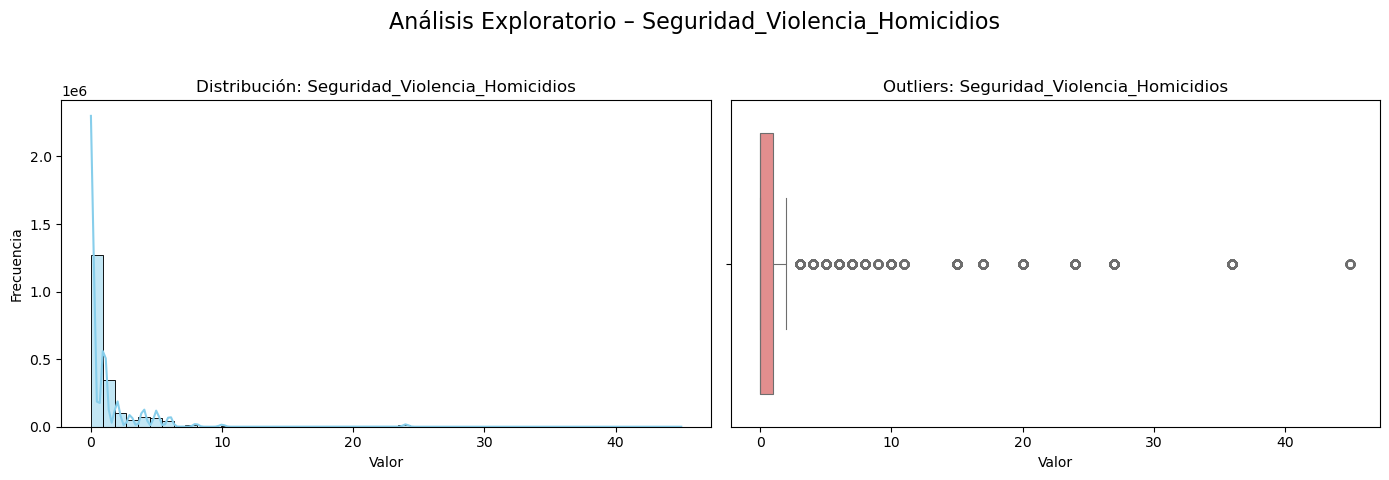

Analizando: Seguridad_Violencia_HomicidiosTransito


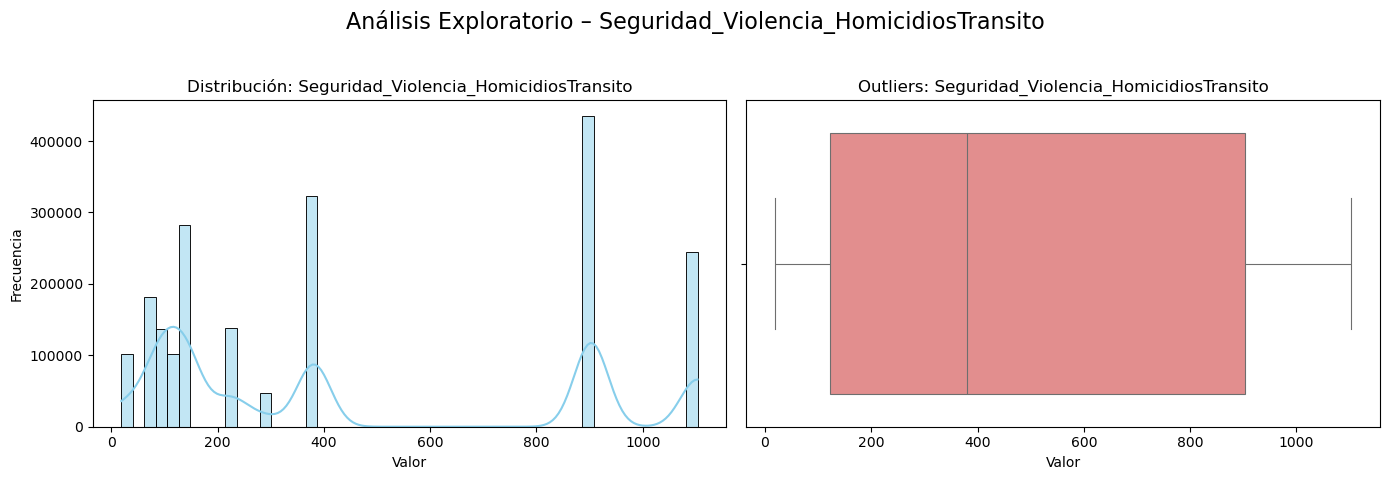

Analizando: Seguridad_Violencia_Lesiones


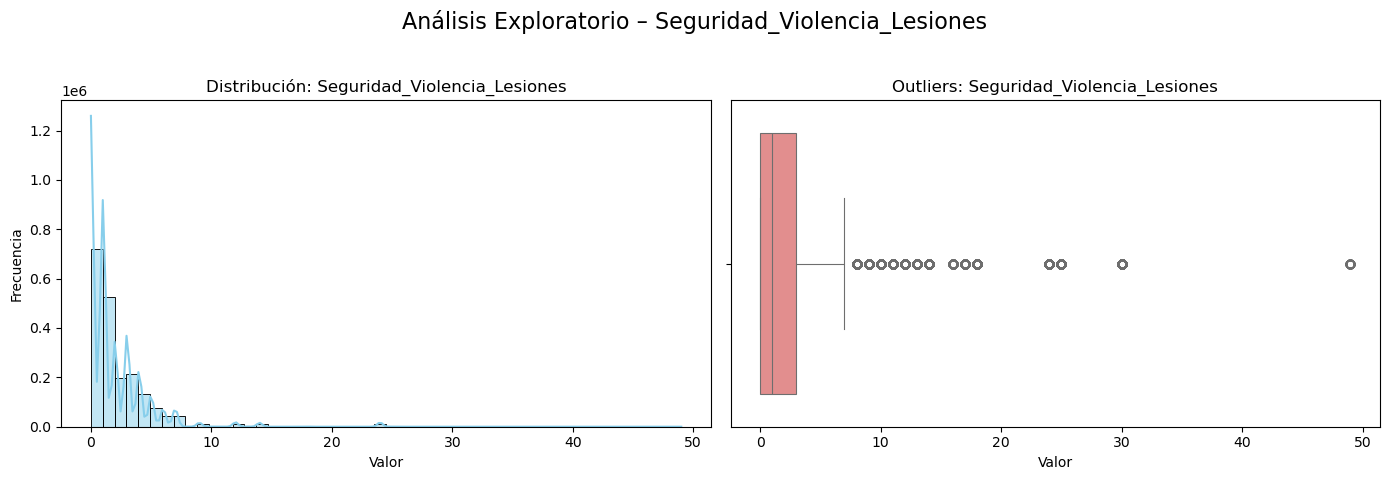

Analizando: Seguridad_Violencia_LesionesTransito


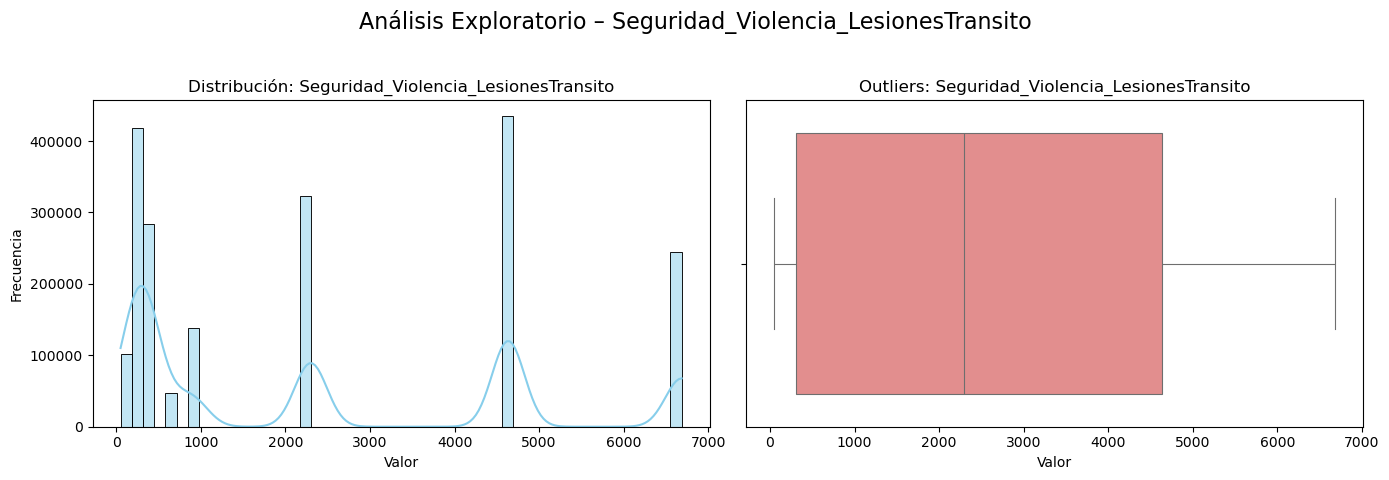

Analizando: Seguridad_Economia_Incautacion_Base_Coca


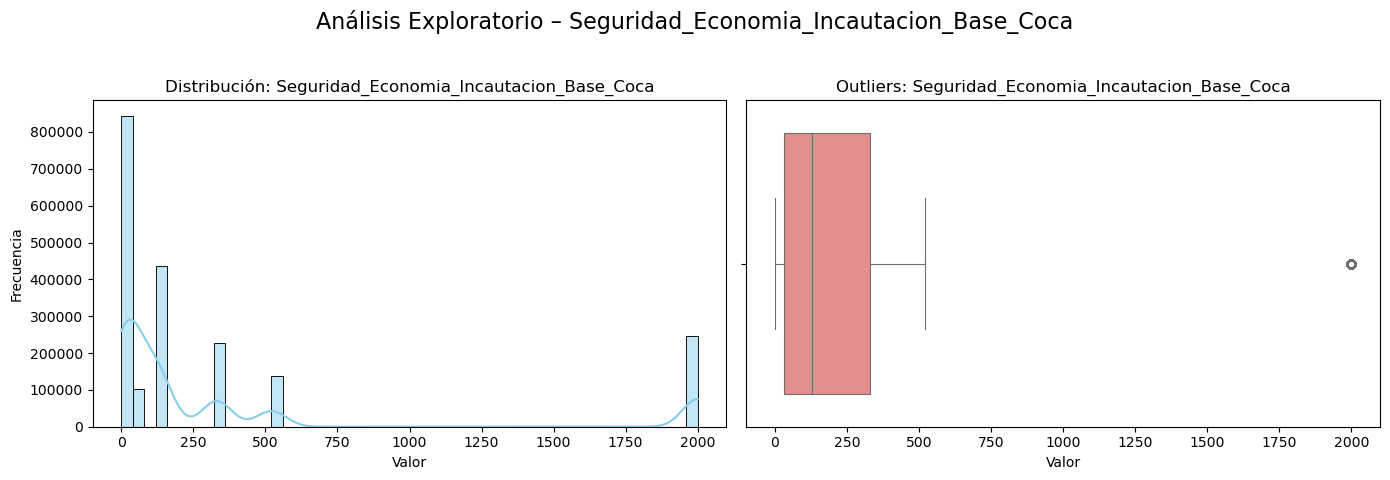

Analizando: Seguridad_Economia_Incautacion_Basuco


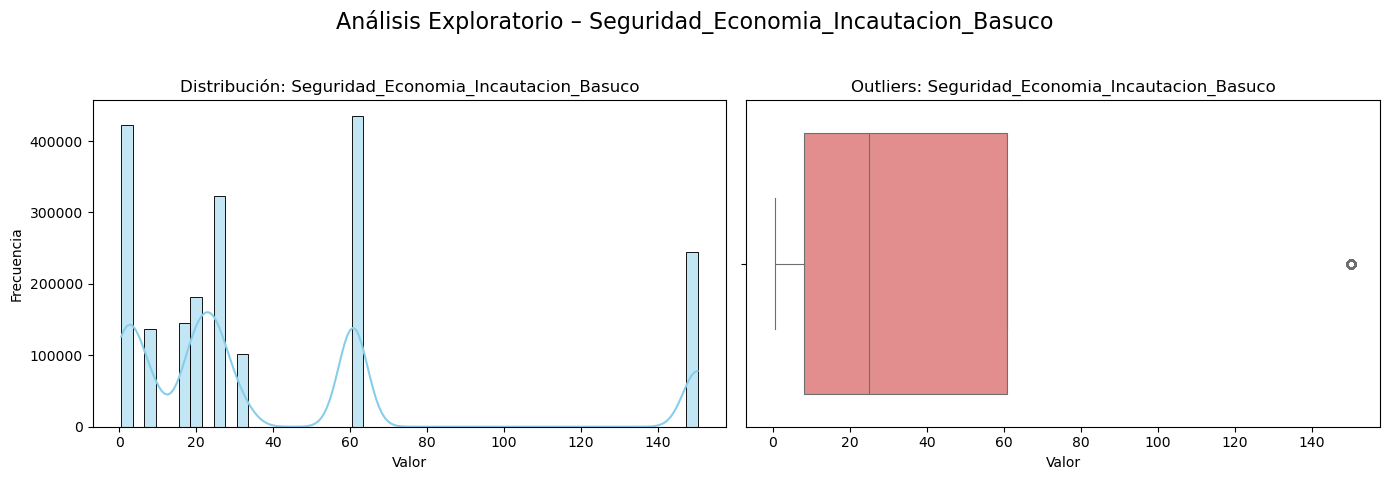

Analizando: Seguridad_Economia_Incautacion_Armas


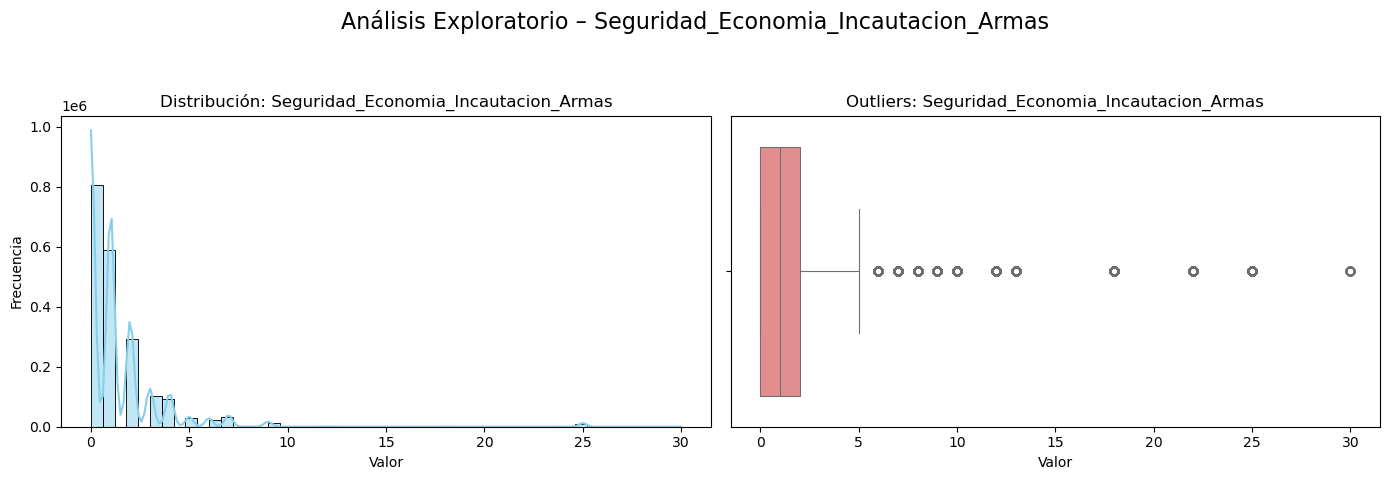

Analizando: Seguridad_Economia_Minas_Antipersona


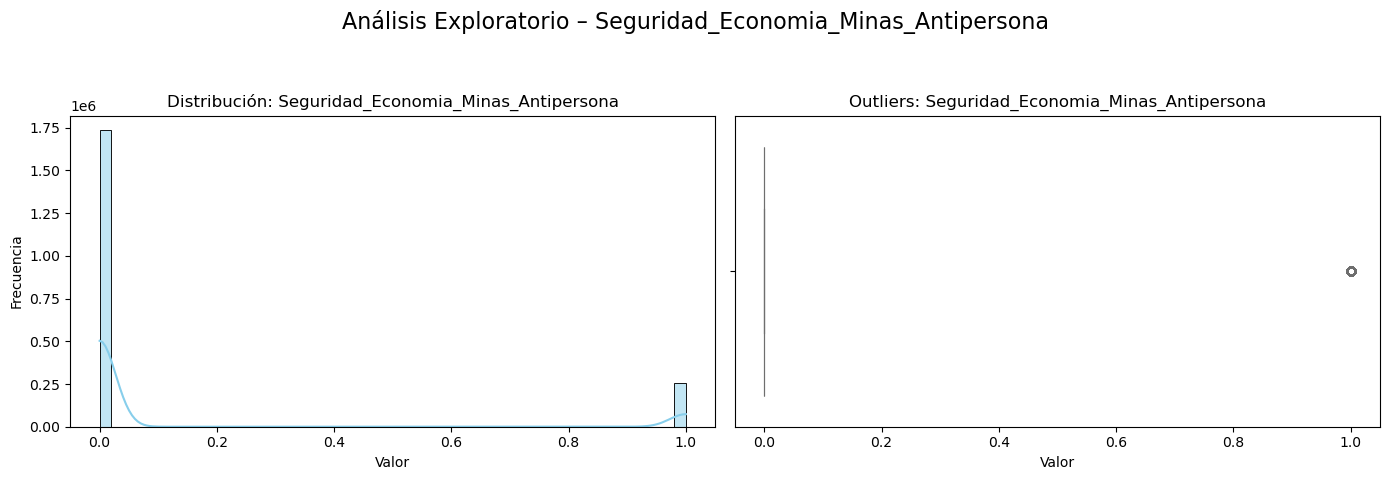

Analizando: Seguridad_Economia_Mineria_Intervenida


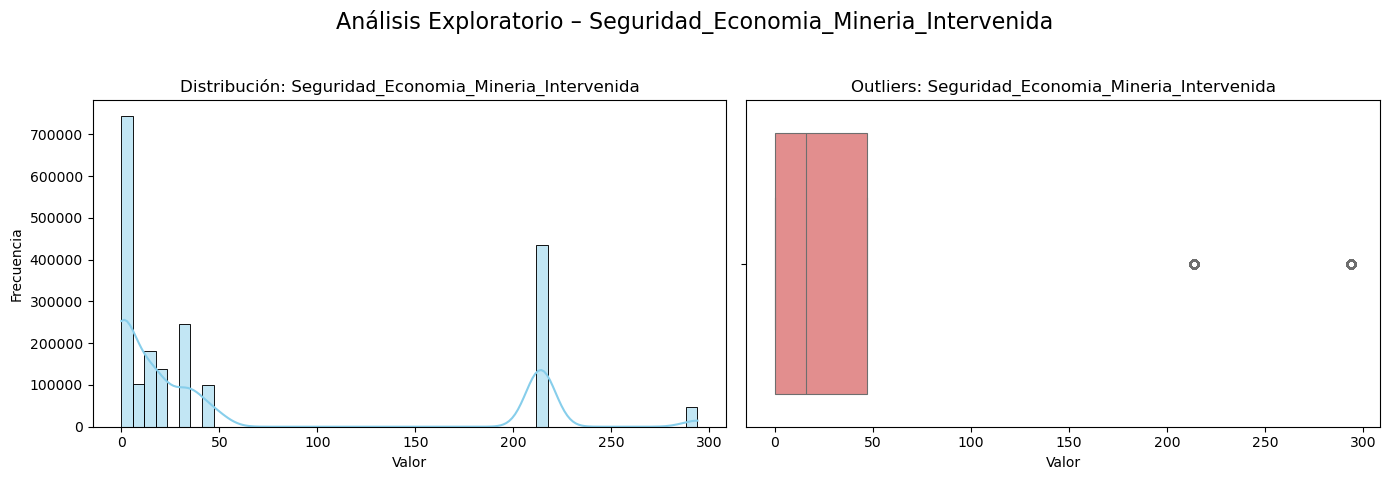

Analizando: Seguridad_Economia_Capturas_Mineria


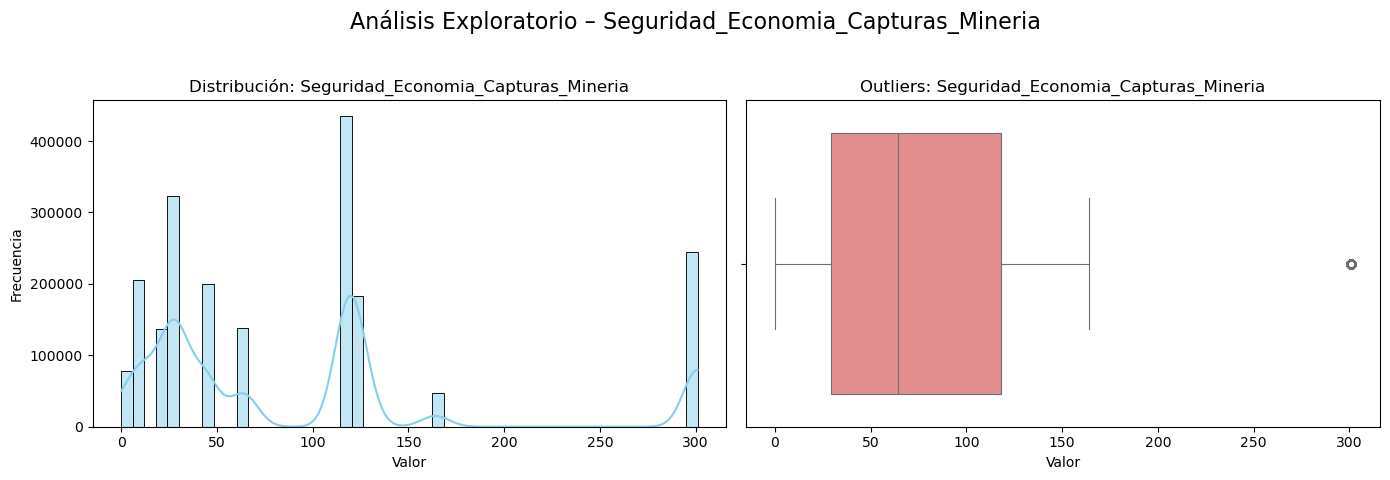

Analizando: Seguridad_Economia_Grupos_Armados_Guerrilla


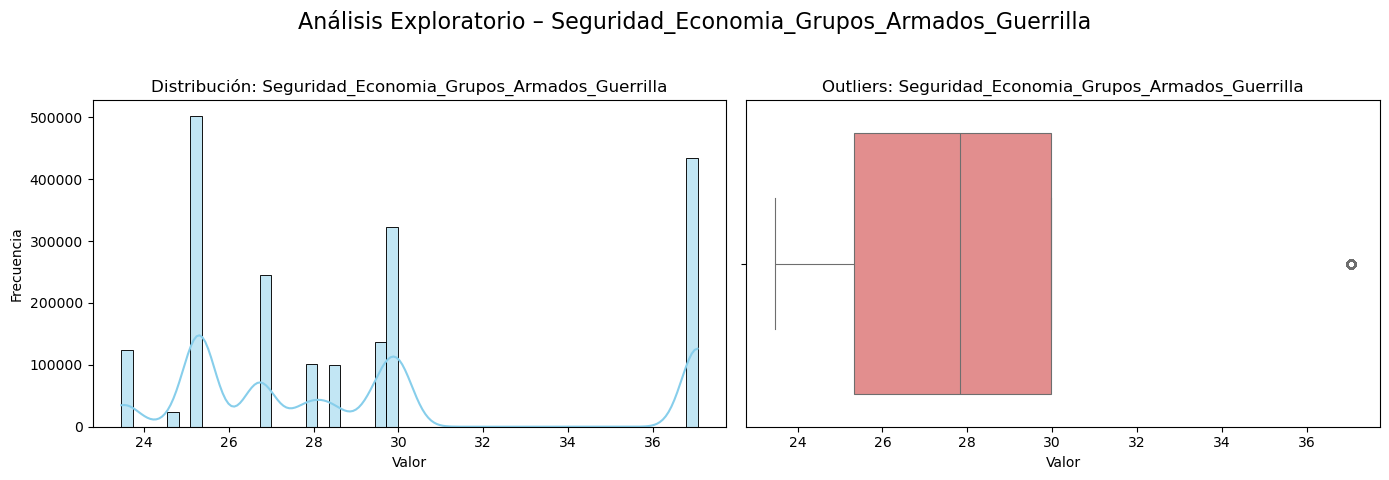

Analizando: Seguridad_Criminalidad_Delitos_Sexuales


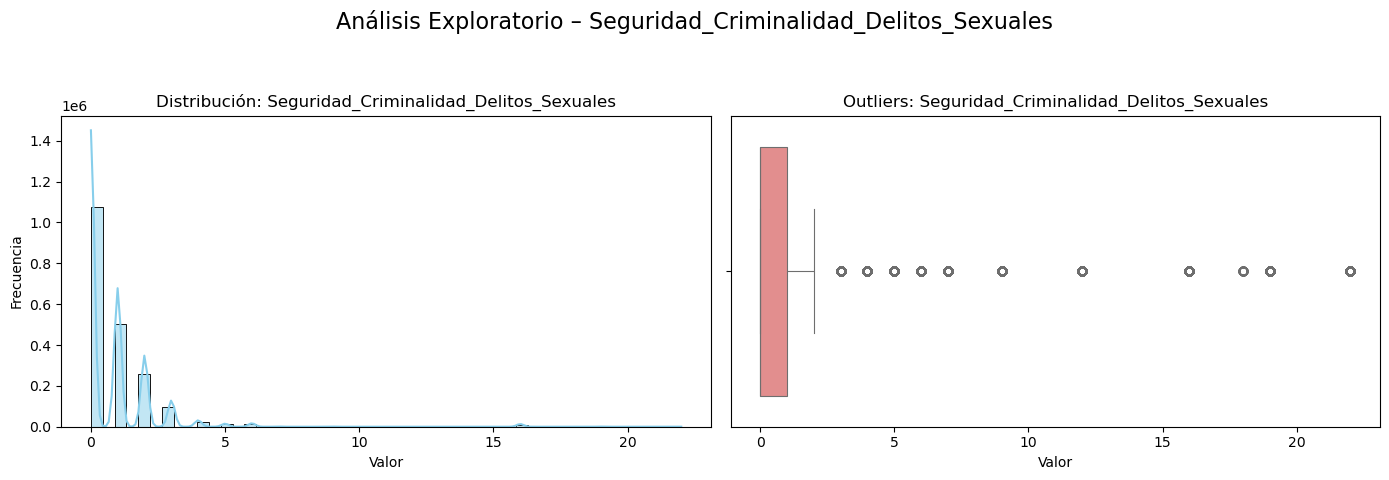

Analizando: Seguridad_Criminalidad_Extorsion


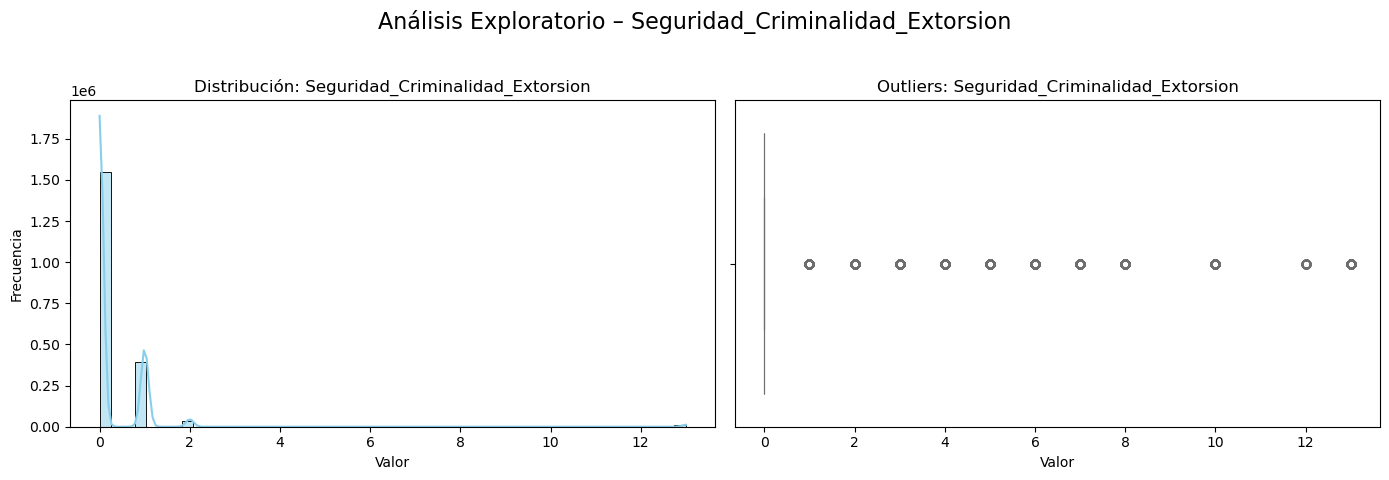

Analizando: Seguridad_Criminalidad_Abiegato


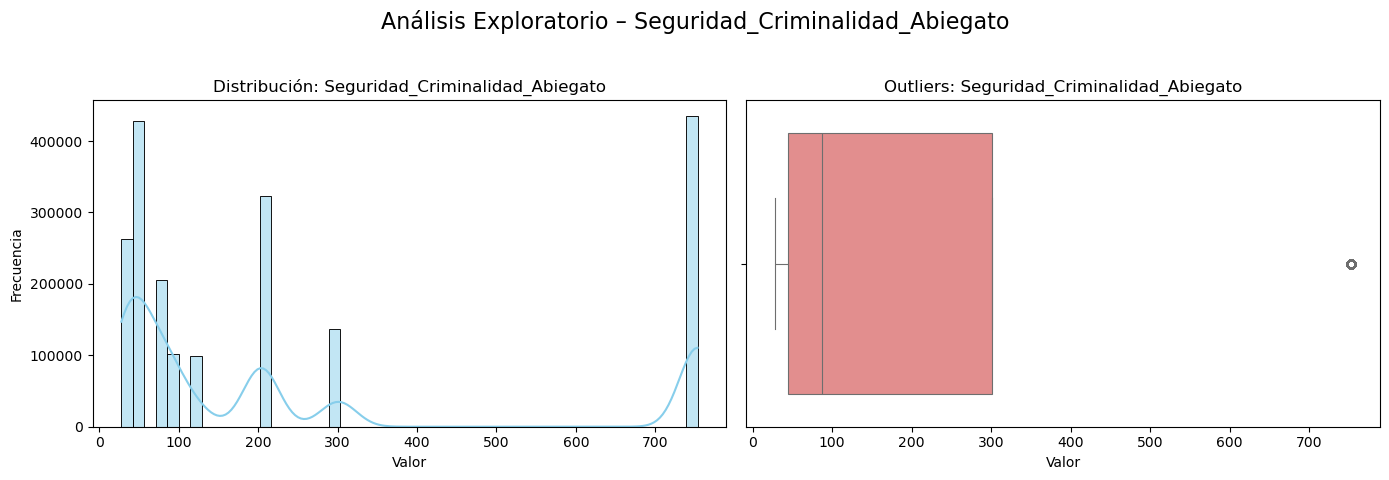

Analizando: Seguridad_Factores_MigrantesIrregulares


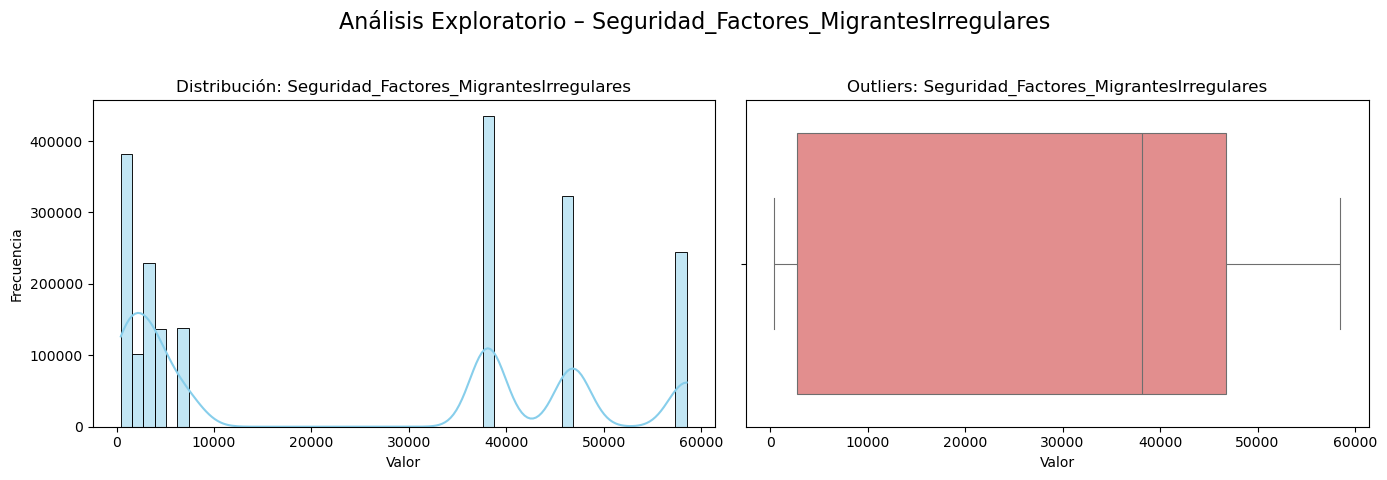

Analizando: Desarrollo_Infraestructura_Acueducto


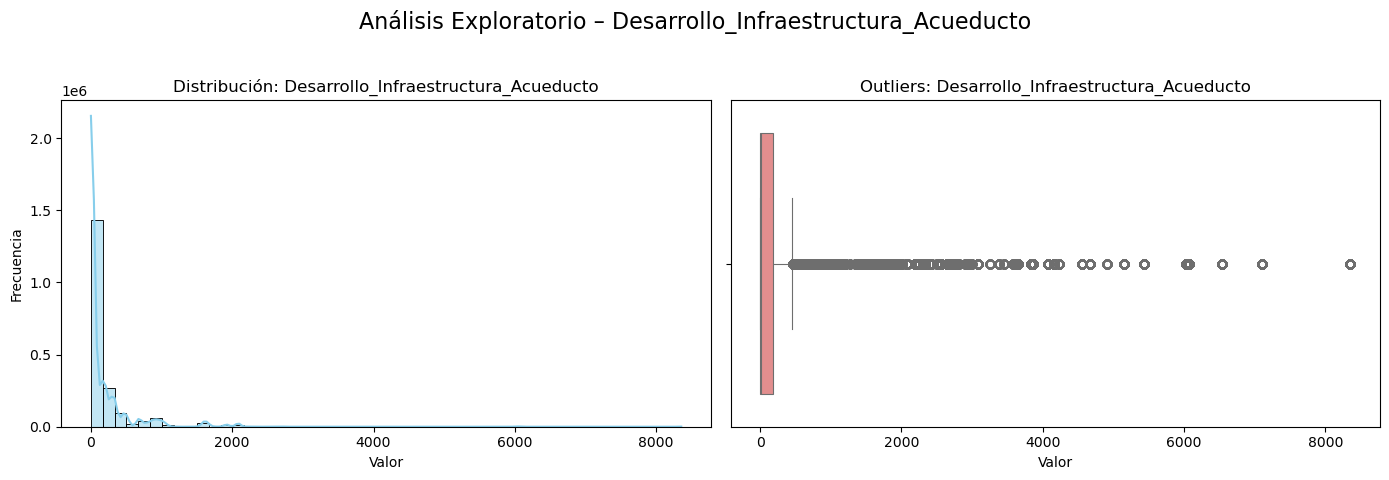

Analizando: Desarrollo_Infraestructura_Energia


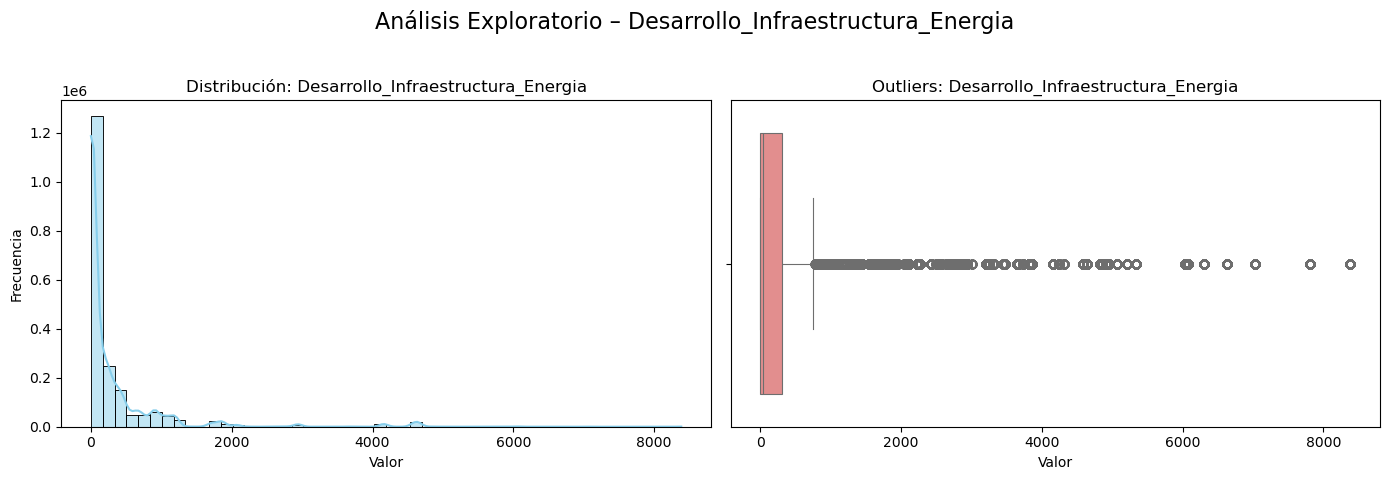

Analizando: Desarrollo_Infraestructura_Gas


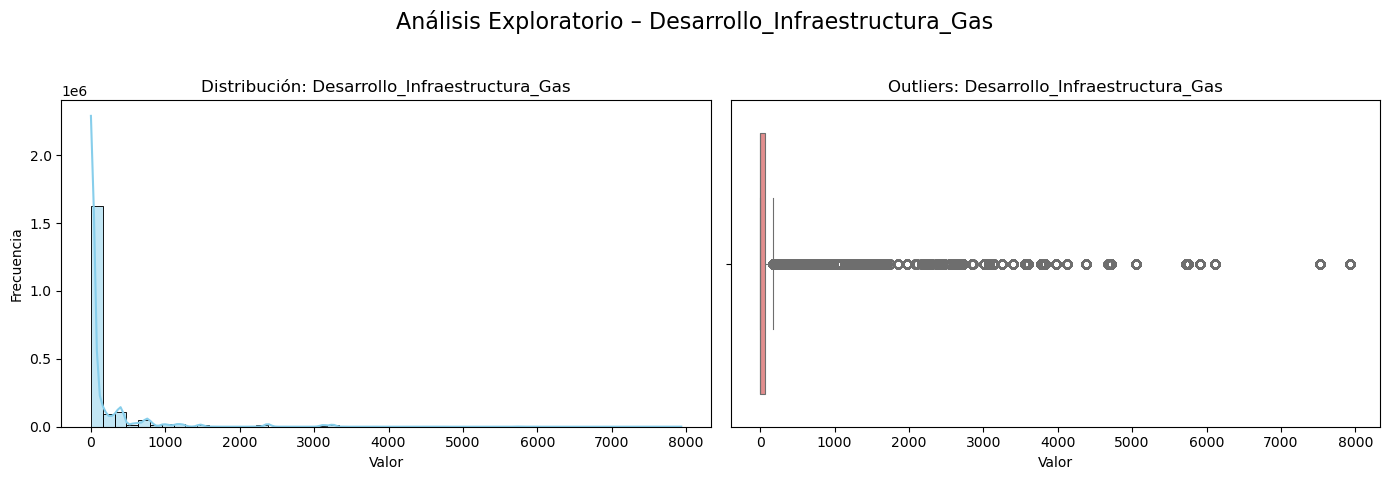

Analizando: Desarrollo_Infraestructura_Internet


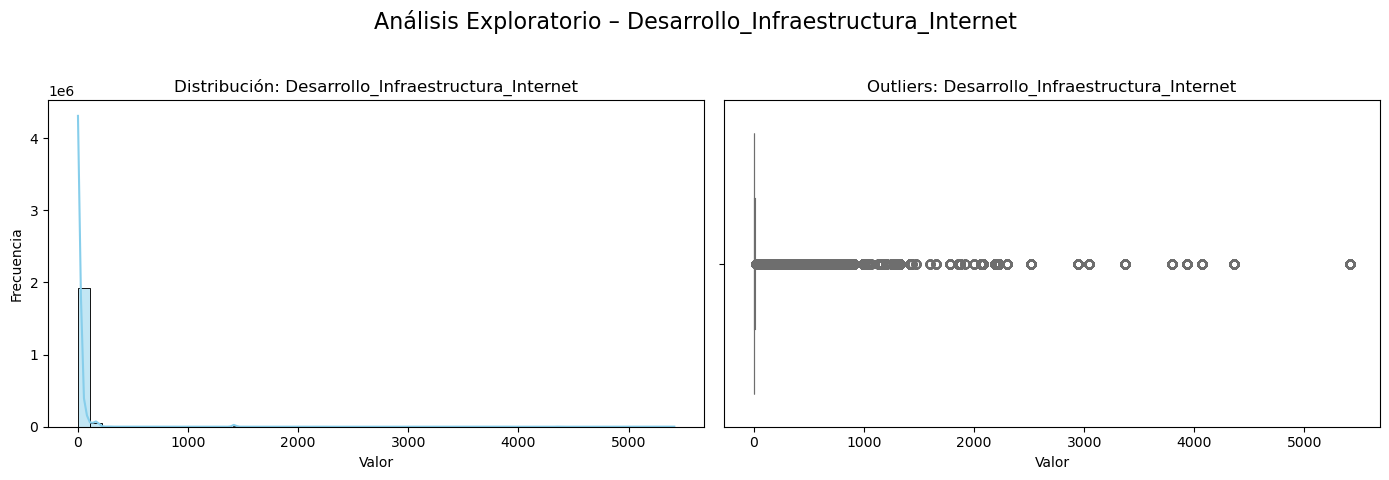

Analizando: Desarrollo_Riesgo_Deslizamiento


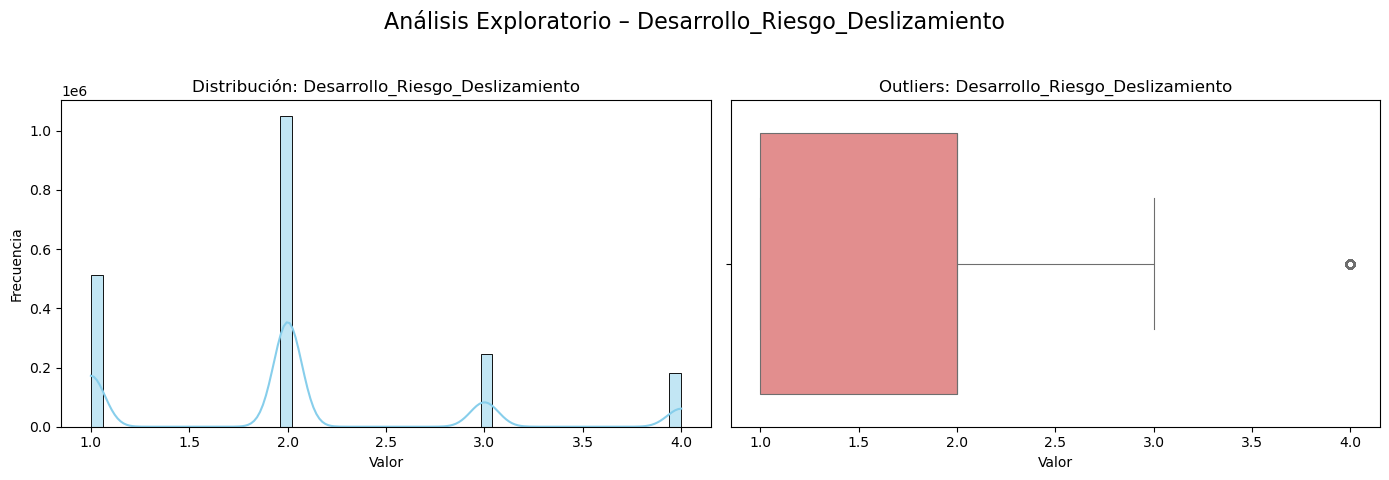

Analizando: Desarrollo_Riesgo_Hidrologica


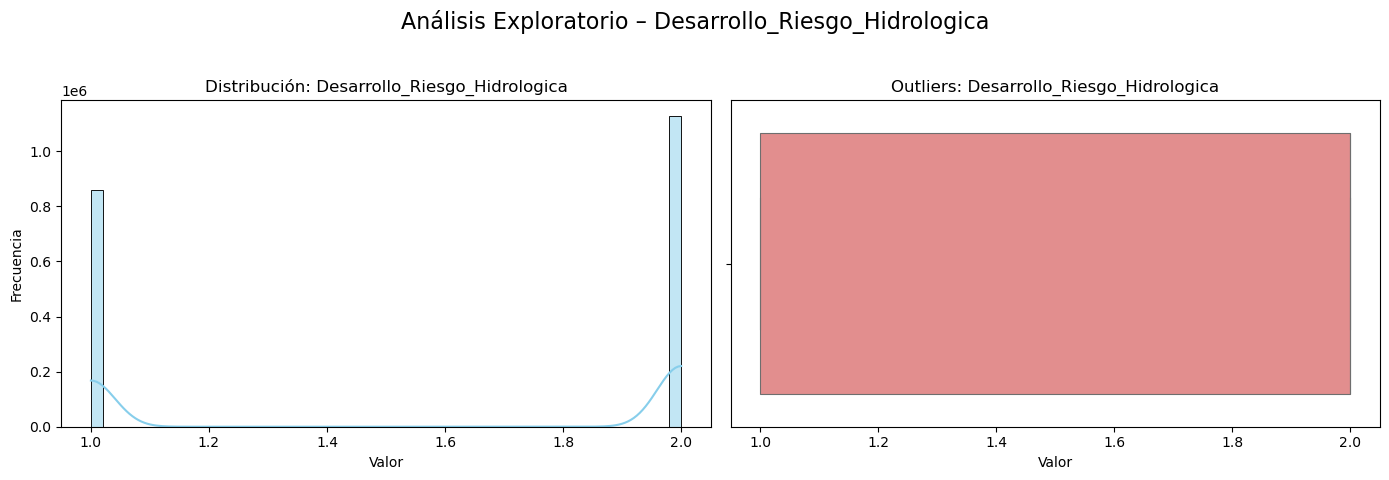

Analizando: Desarrollo_Riesgo_Incendios


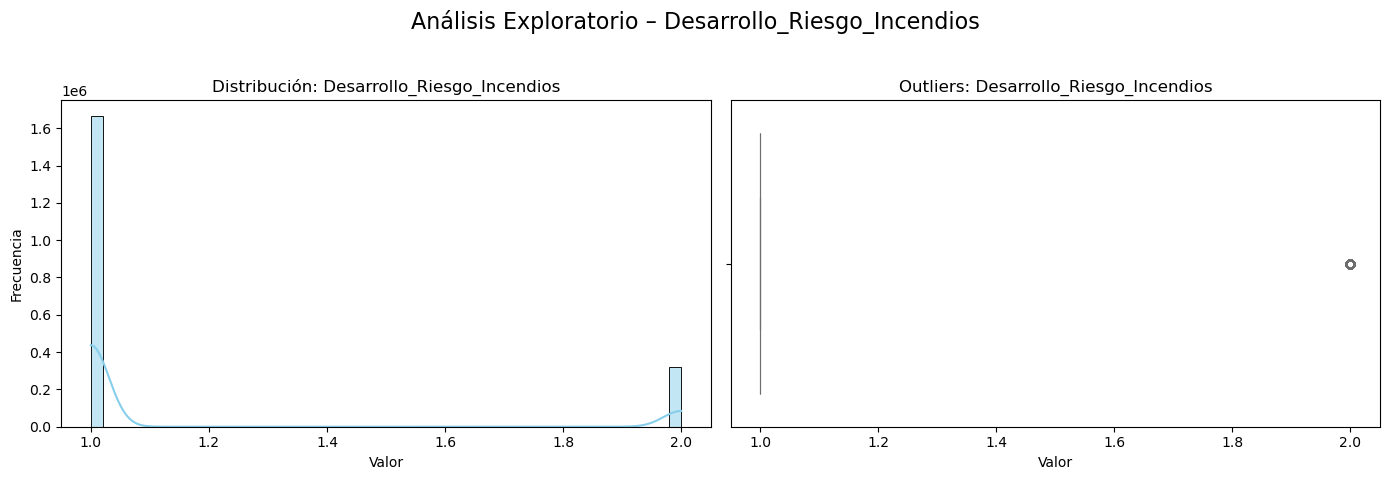

Analizando: Desarrollo_Humano_Alfabetismo


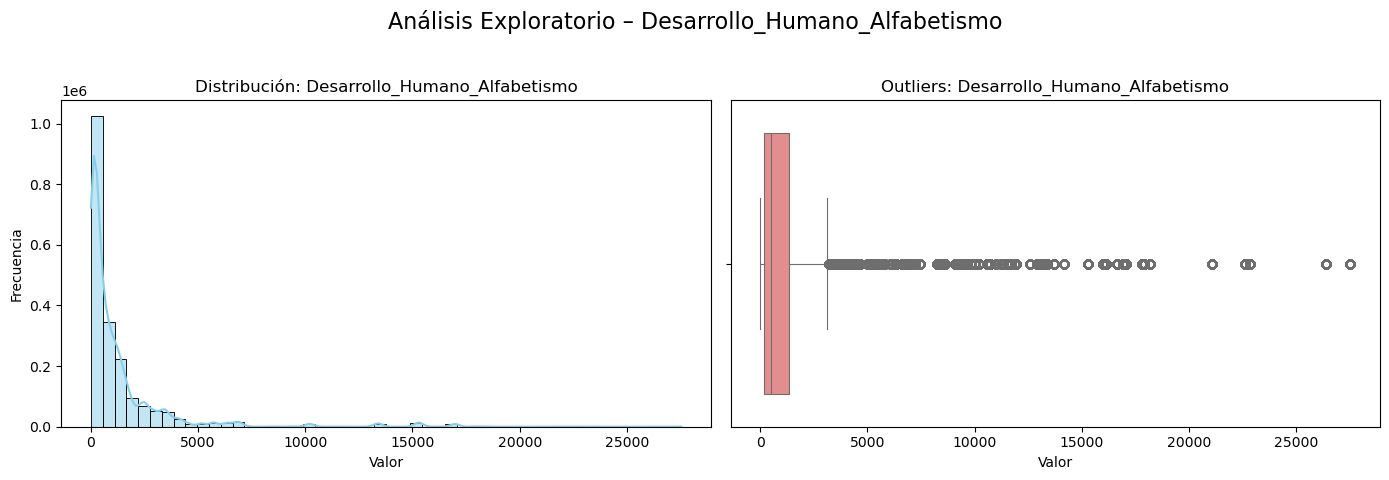

Analizando: Desarrollo_Humano_Educacion


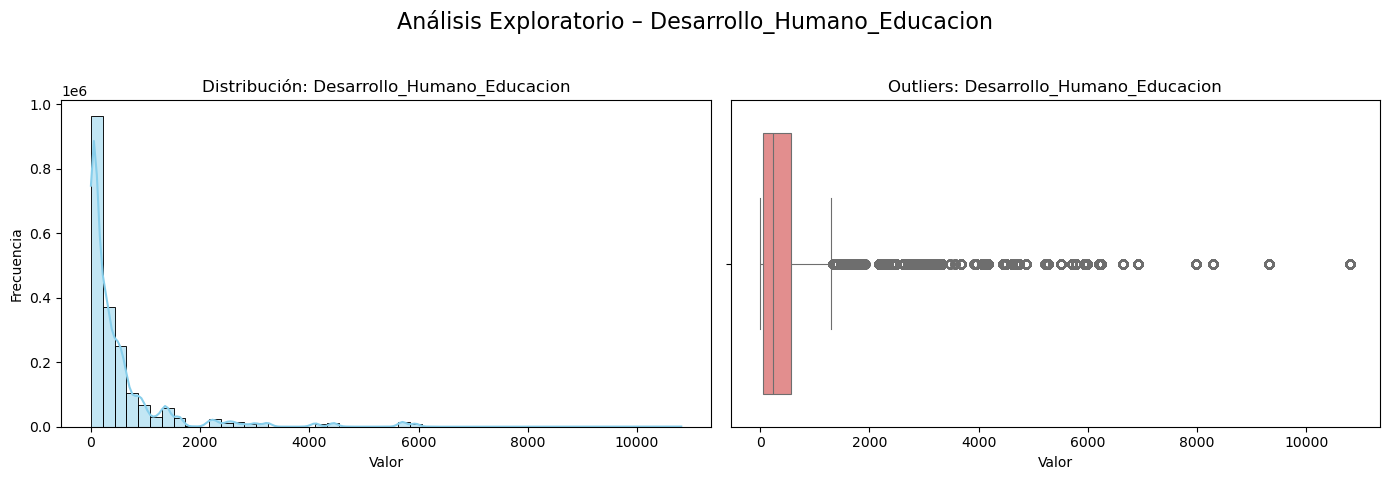

Analizando: Desarrollo_Humano_BajoPeso


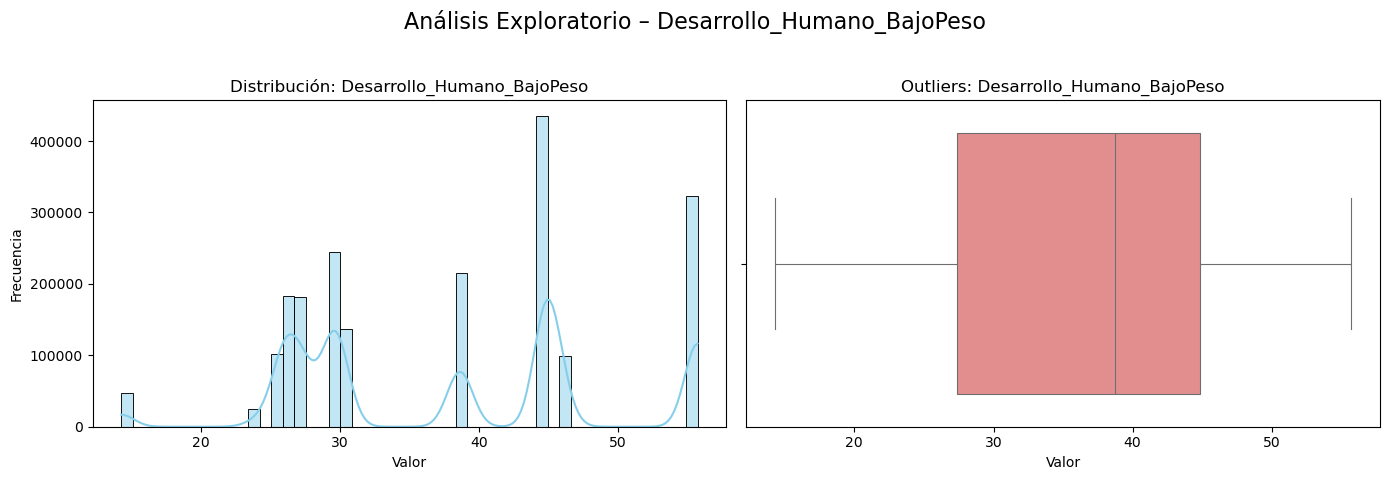

Analizando: Desarrollo_Humano_Desnutricion


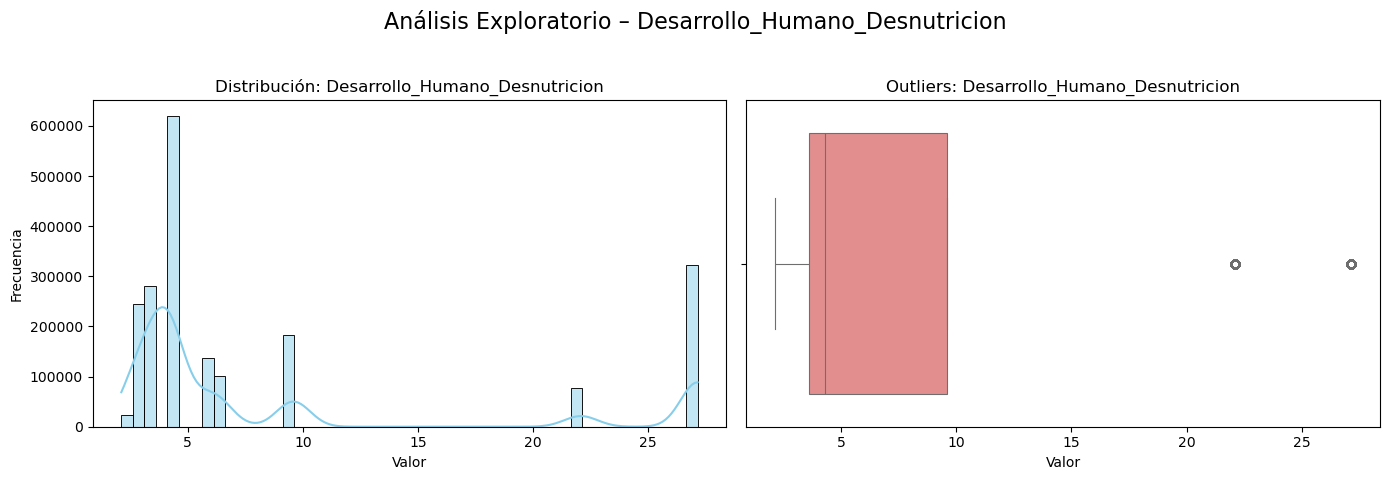

Analizando: Desarrollo_Factores_Desempleo


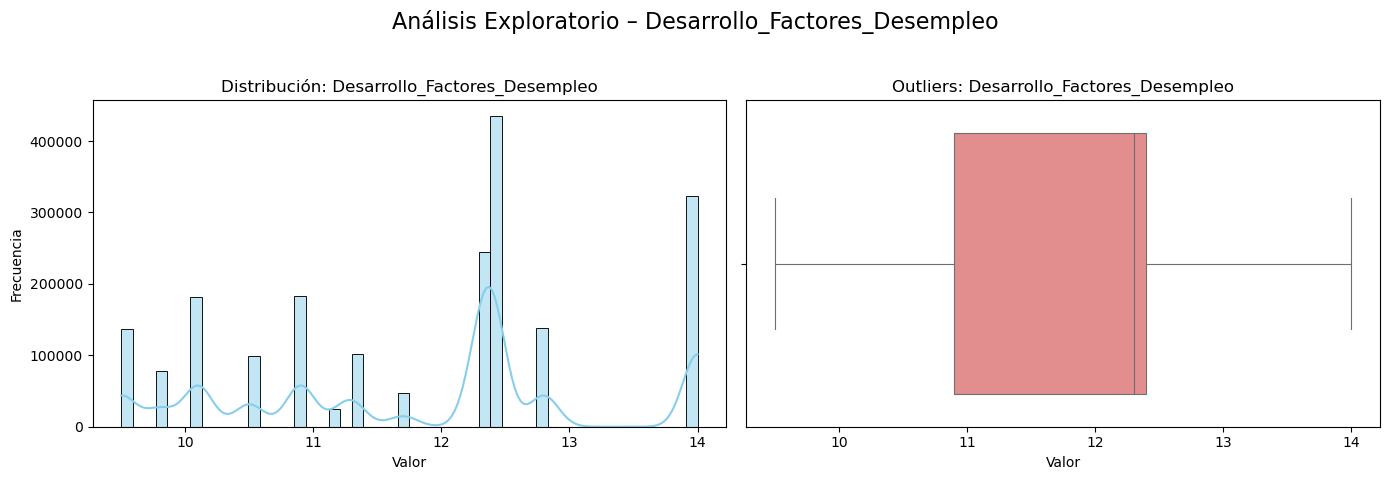

Analizando: Desarrollo_Factores_IPM


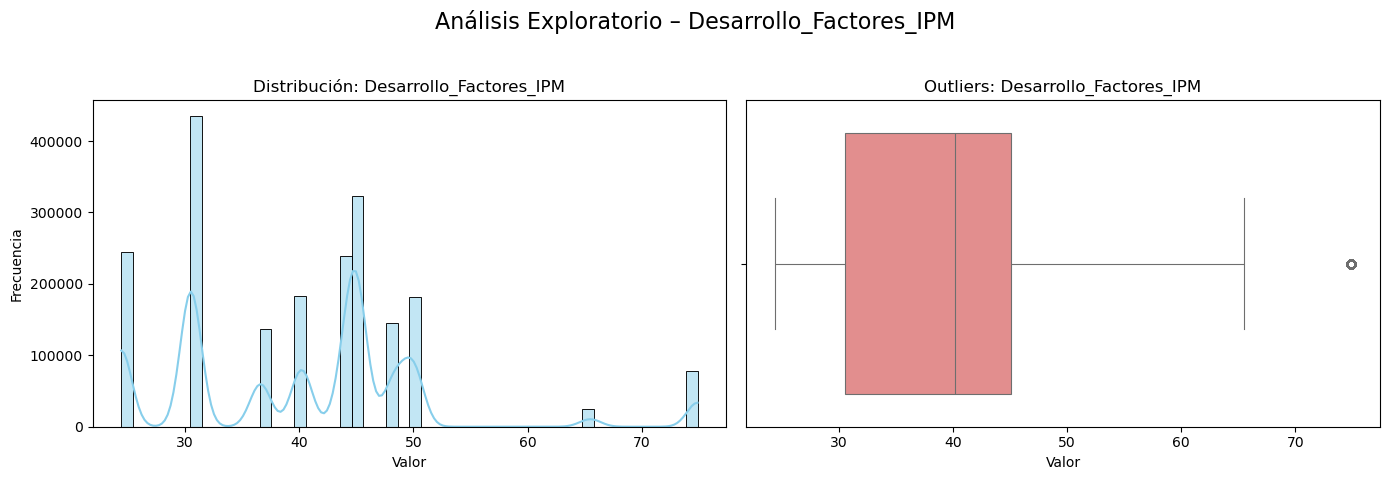

Analizando: Gobernabilidad_Infraestructura_Salud


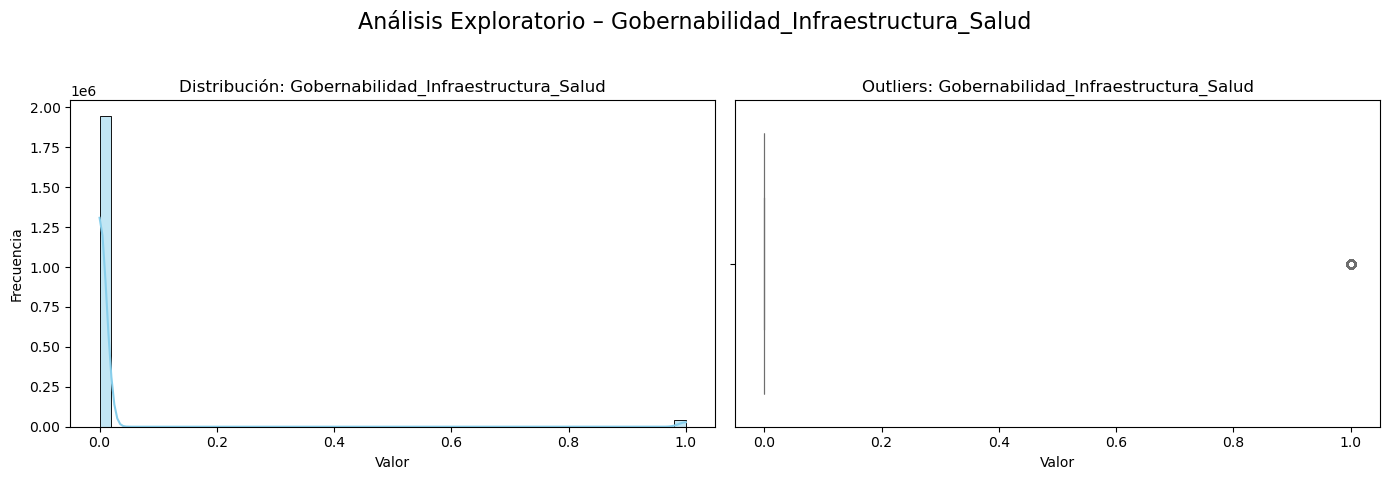

Analizando: Seguridad_Criminalidad_Estaciones_Policia


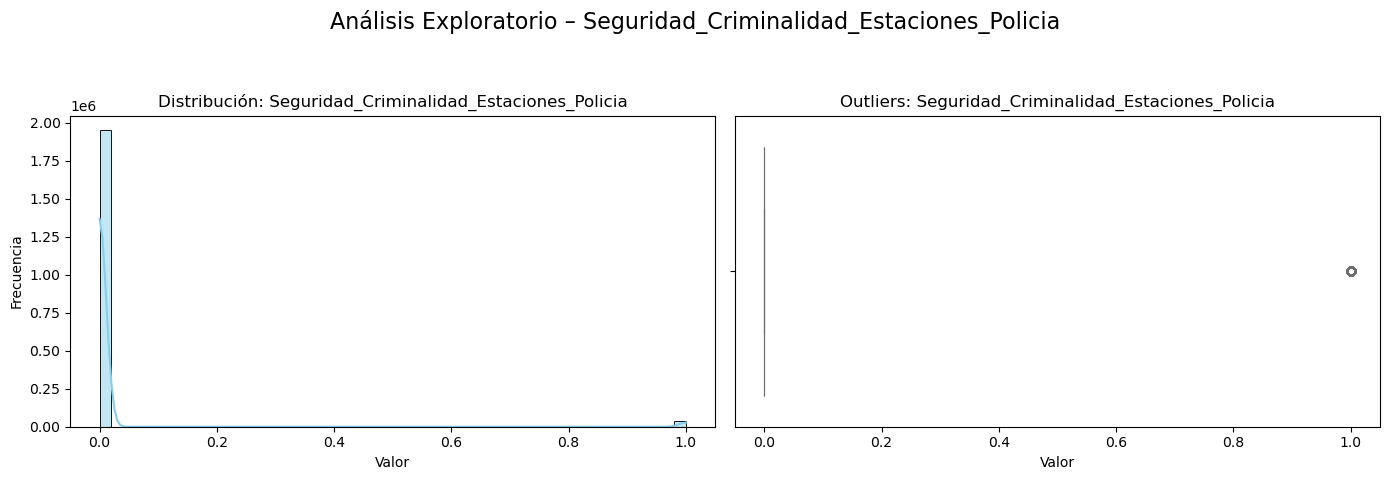

Analizando: Gobernabilidad_Infraestructura_Educacion


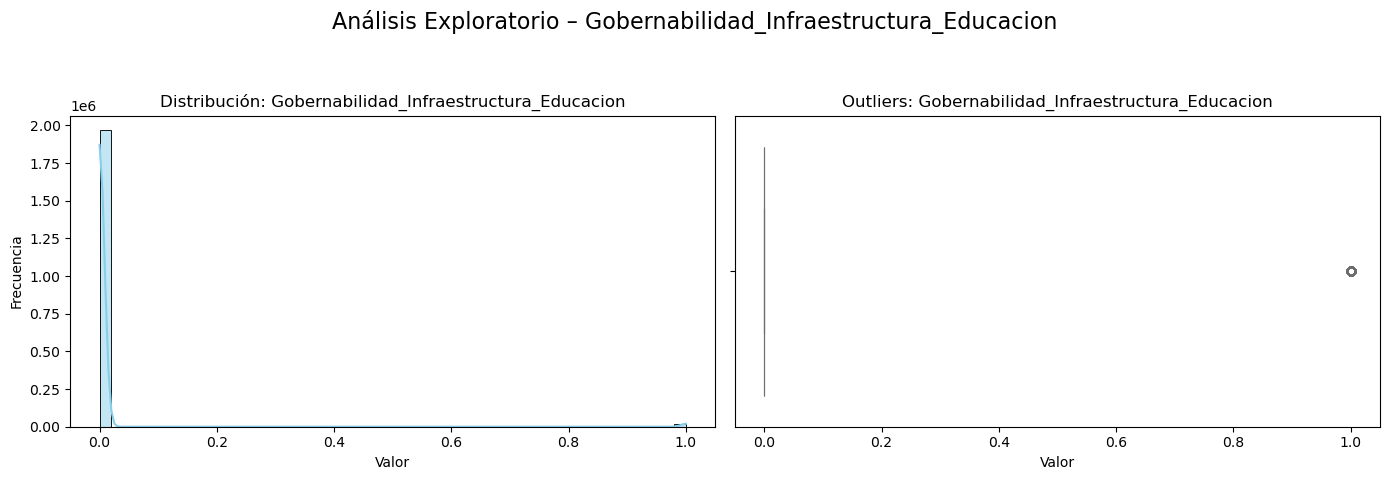

Analizando: Gobernabilidad_Territorio_Censo


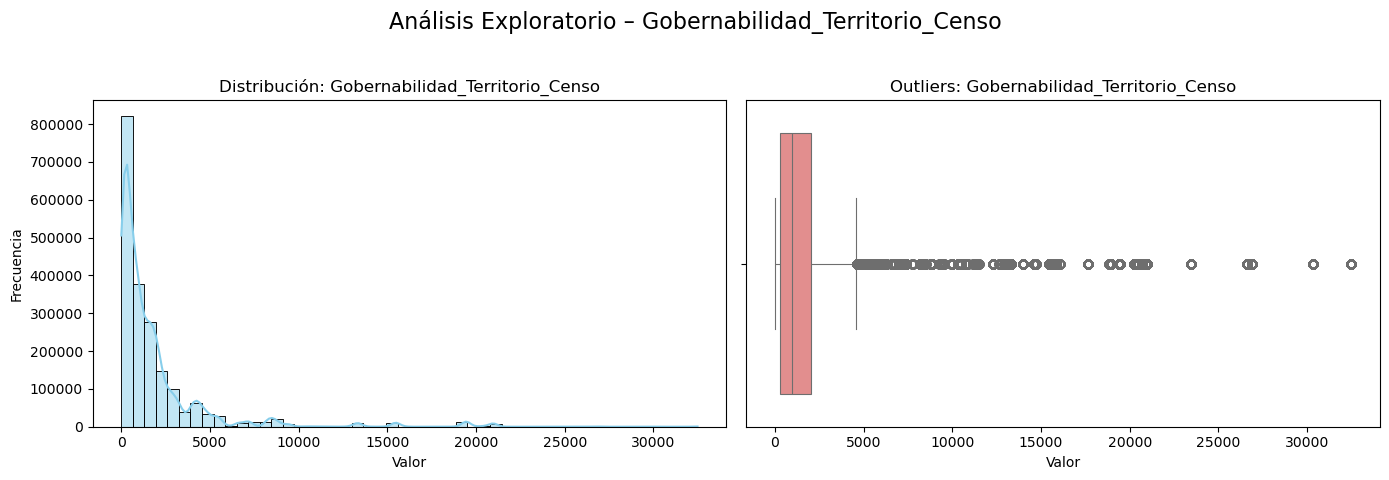

Analizando: Gobernabilidad_Territorio_Comunidades2


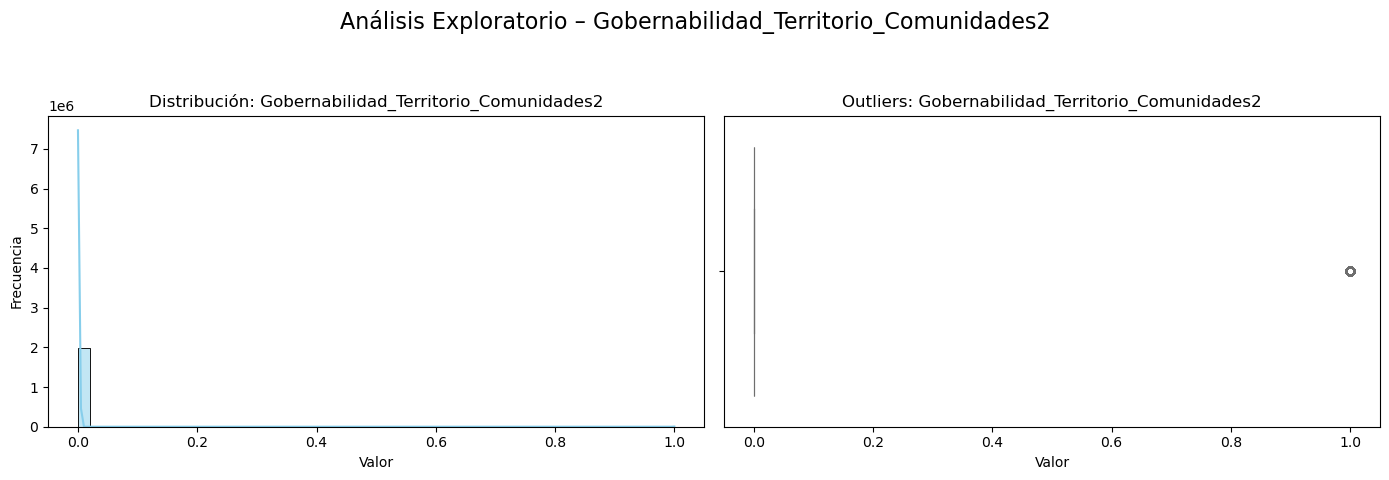

Analizando: Gobernabilidad_Territorio_Indigenas


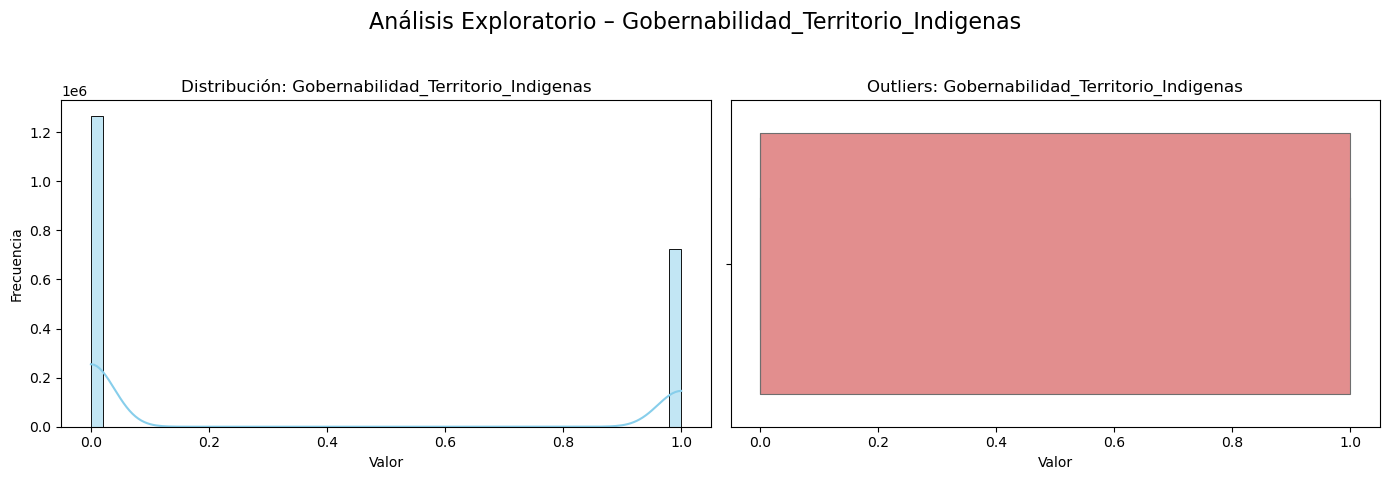

Analizando: Gobernabilidad_Territorio_Protegidas


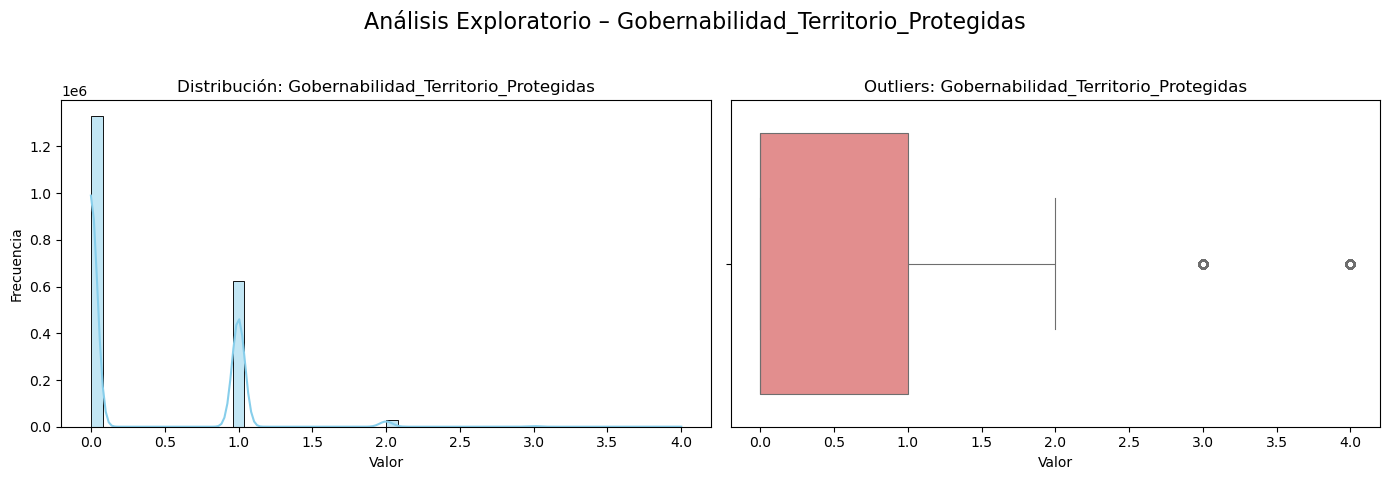

Analizando: Gobernabilidad_Planeacion_Turistico


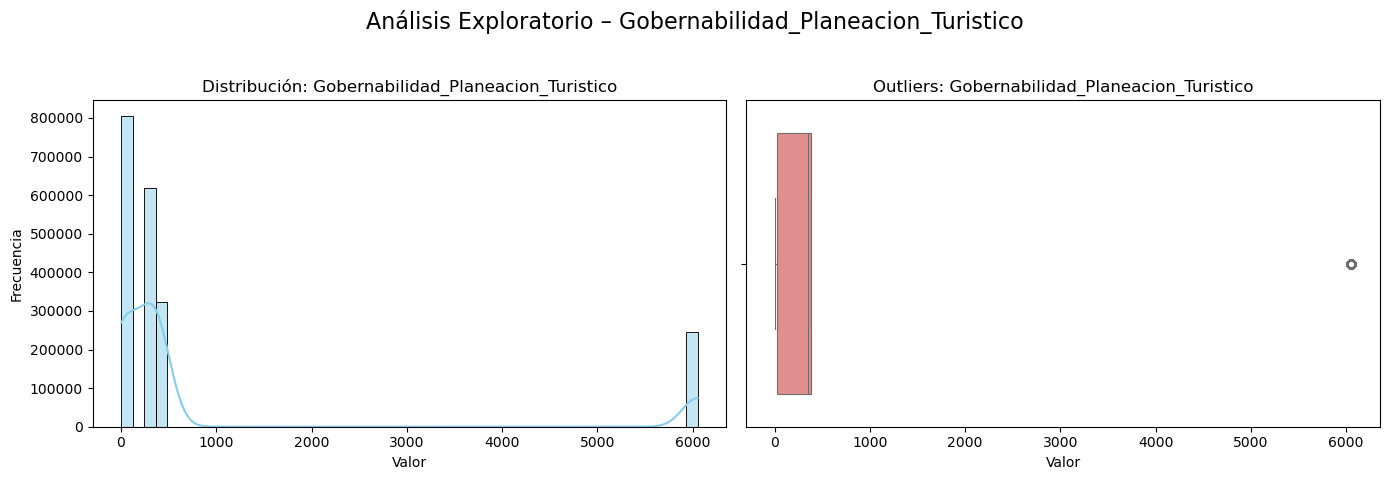

Analizando: Gobernabilidad_Planeacion_Hoteles


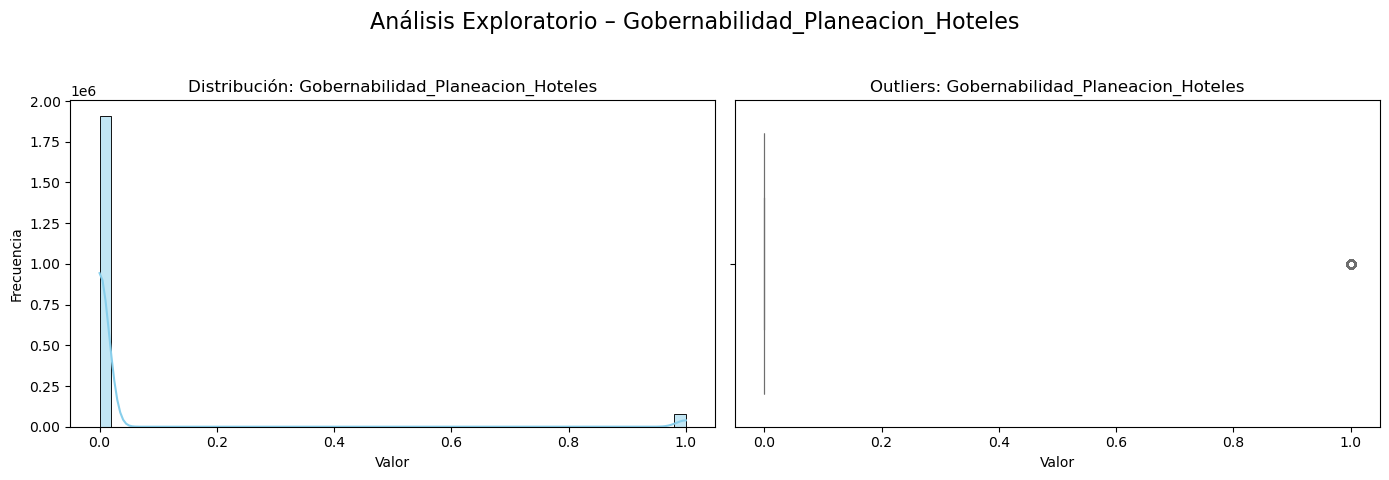

Analizando: Seguridad_Factores_AtentadosSIEVCA


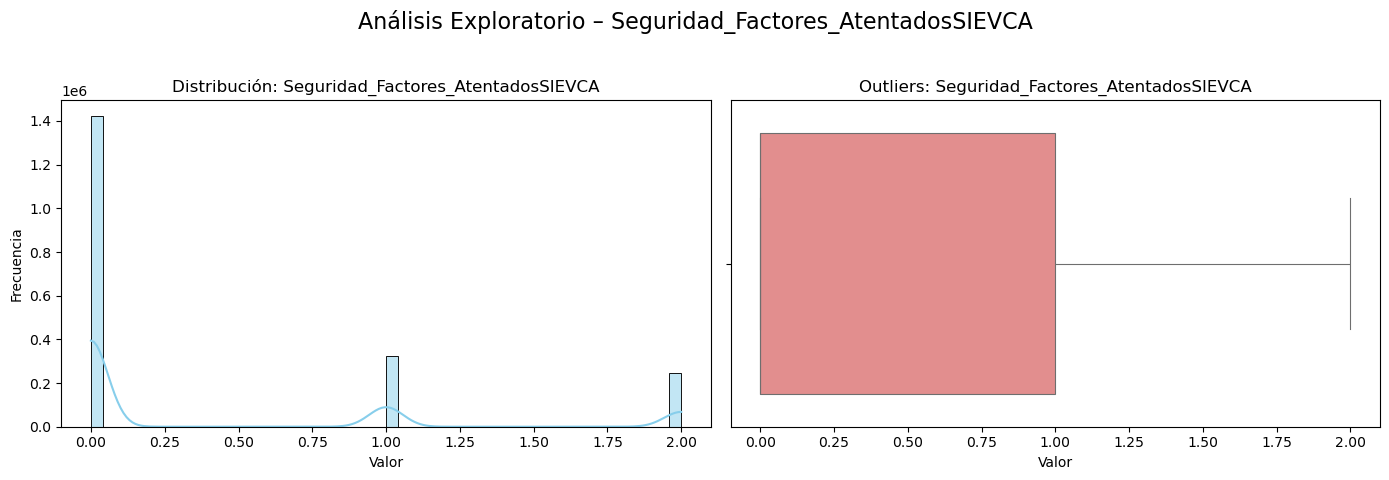

Analizando: Seguridad_Economia_Presencia_Ejercito


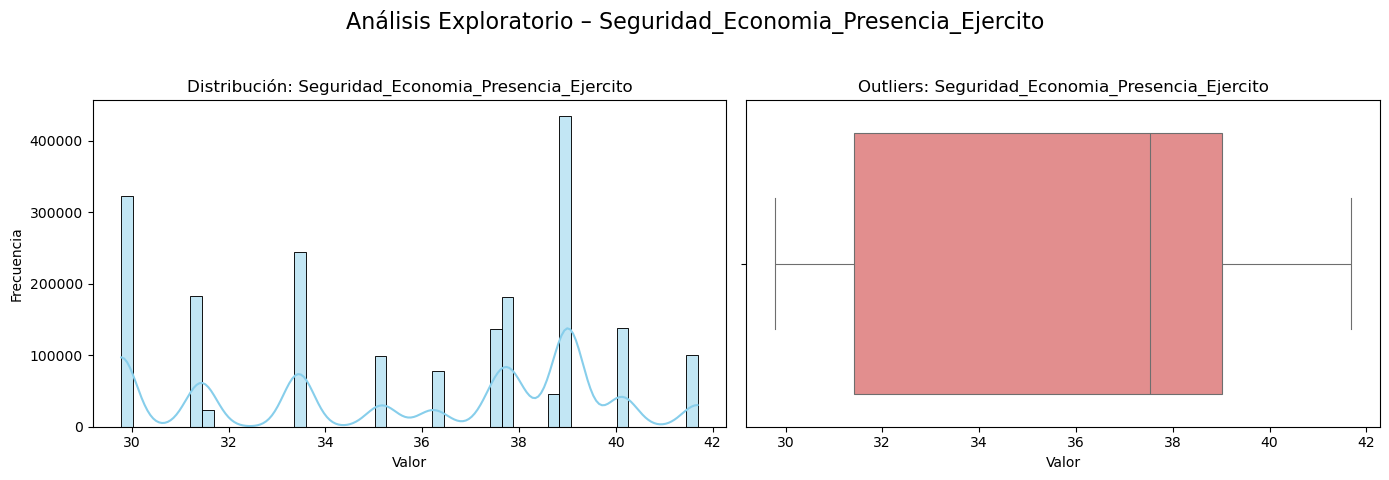

Analizando: Seguridad_Economia_Incautacion_Cocaina


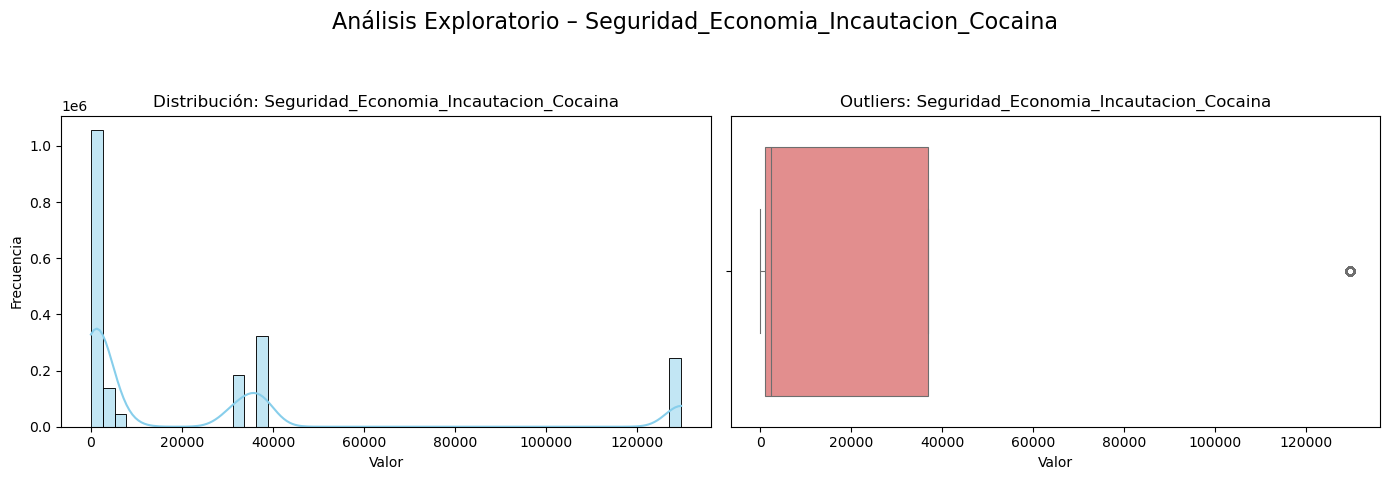

✅ Análisis por variable completado.


In [16]:
output_dir = r"C:\Users\Sebastian\Documents\ArcGIS\Projects\CIDENAL"
os.makedirs(output_dir, exist_ok=True)

BINS       = 50         
BW_ADJUST  = 2.0         

for col in df.columns:
    print(f"Analizando: {col}")

    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    sns.histplot(
        df[col].dropna(),
        bins=50,
        kde=True,
        kde_kws={'bw_adjust': 1.5},  
        ax=axs[0],
        color="skyblue"
    )

    axs[0].set_title(f"Distribución: {col}")
    axs[0].set_xlabel("Valor")
    axs[0].set_ylabel("Frecuencia")

    # Boxplot
    sns.boxplot(
        x=df[col].dropna(),
        ax=axs[1],
        color="lightcoral",
        linewidth=0.8
    )
    axs[1].set_title(f"Outliers: {col}")
    axs[1].set_xlabel("Valor")

    plt.suptitle(f"Análisis Exploratorio – {col}", fontsize=16)

    # Guardar imagen
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # deja espacio para el título
    plt.savefig(os.path.join(output_dir, f"EDA_{col}.png"), dpi=150)
    plt.show()

print("✅ Análisis por variable completado.")

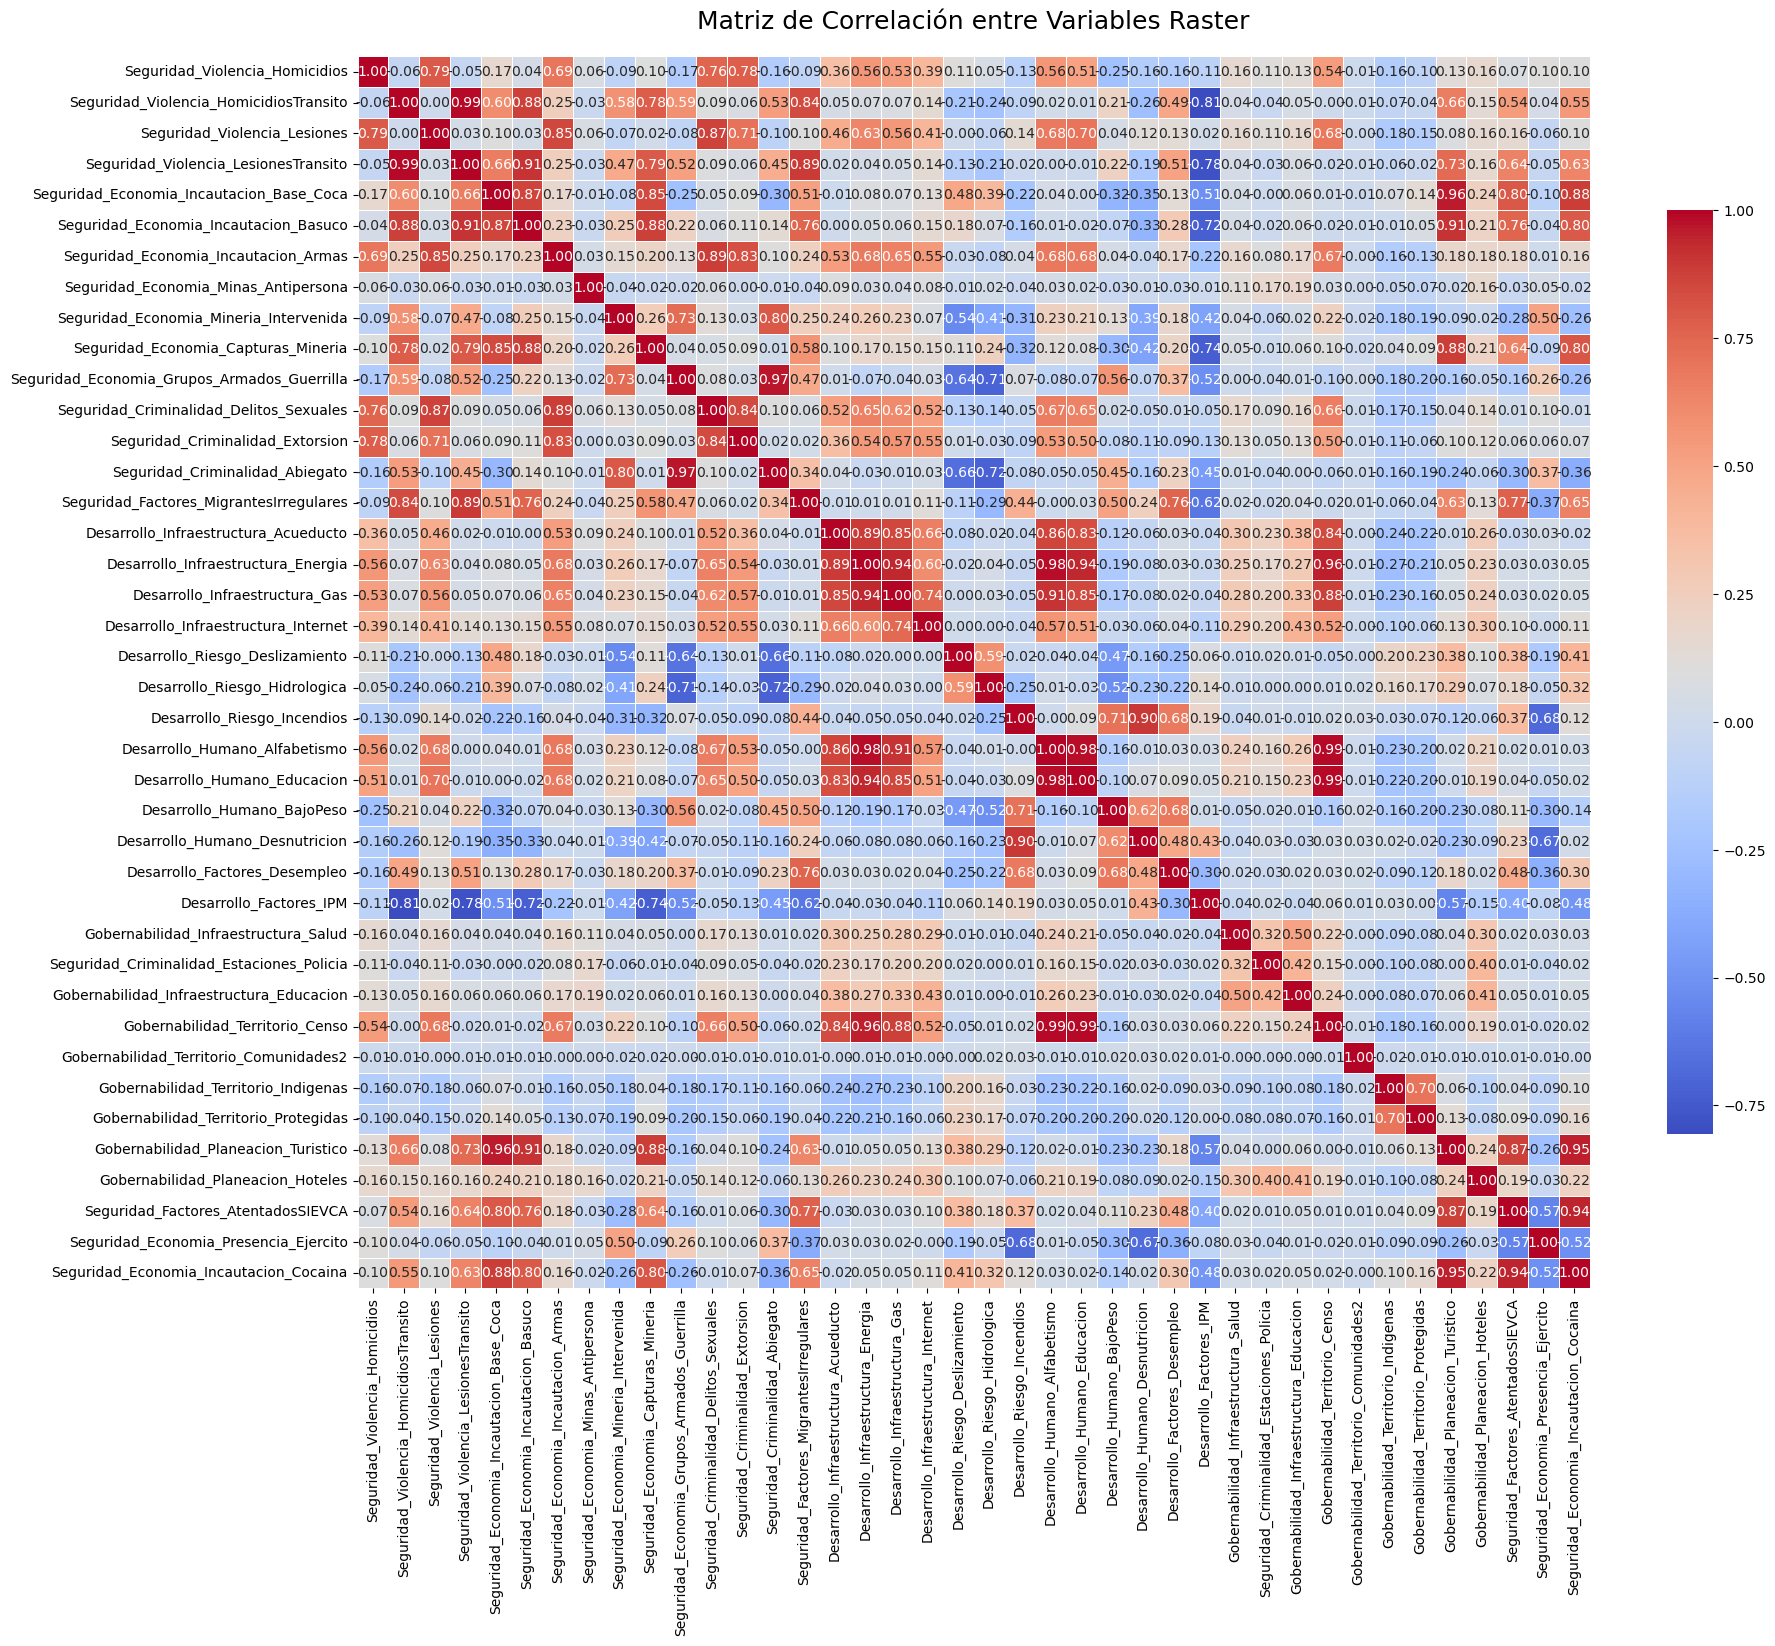

 Matriz de correlación guardada en: C:\Users\Sebastian\Documents\Resultados_EDA\Matriz_Correlacion.png


In [8]:
output_dir = r"C:\Users\Sebastian\Documents\Resultados_EDA"
os.makedirs(output_dir, exist_ok=True)

corr_matrix = df.corr()

plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True,
            linewidths=0.5, cbar_kws={"shrink": .75})

plt.title("Matriz de Correlación entre Variables Raster", fontsize=18, pad=20)

output_path = os.path.join(output_dir, "Matriz_Correlacion.png")
plt.savefig(output_path, dpi=200, bbox_inches='tight')
plt.show()

print(f" Matriz de correlación guardada en: {output_path}")


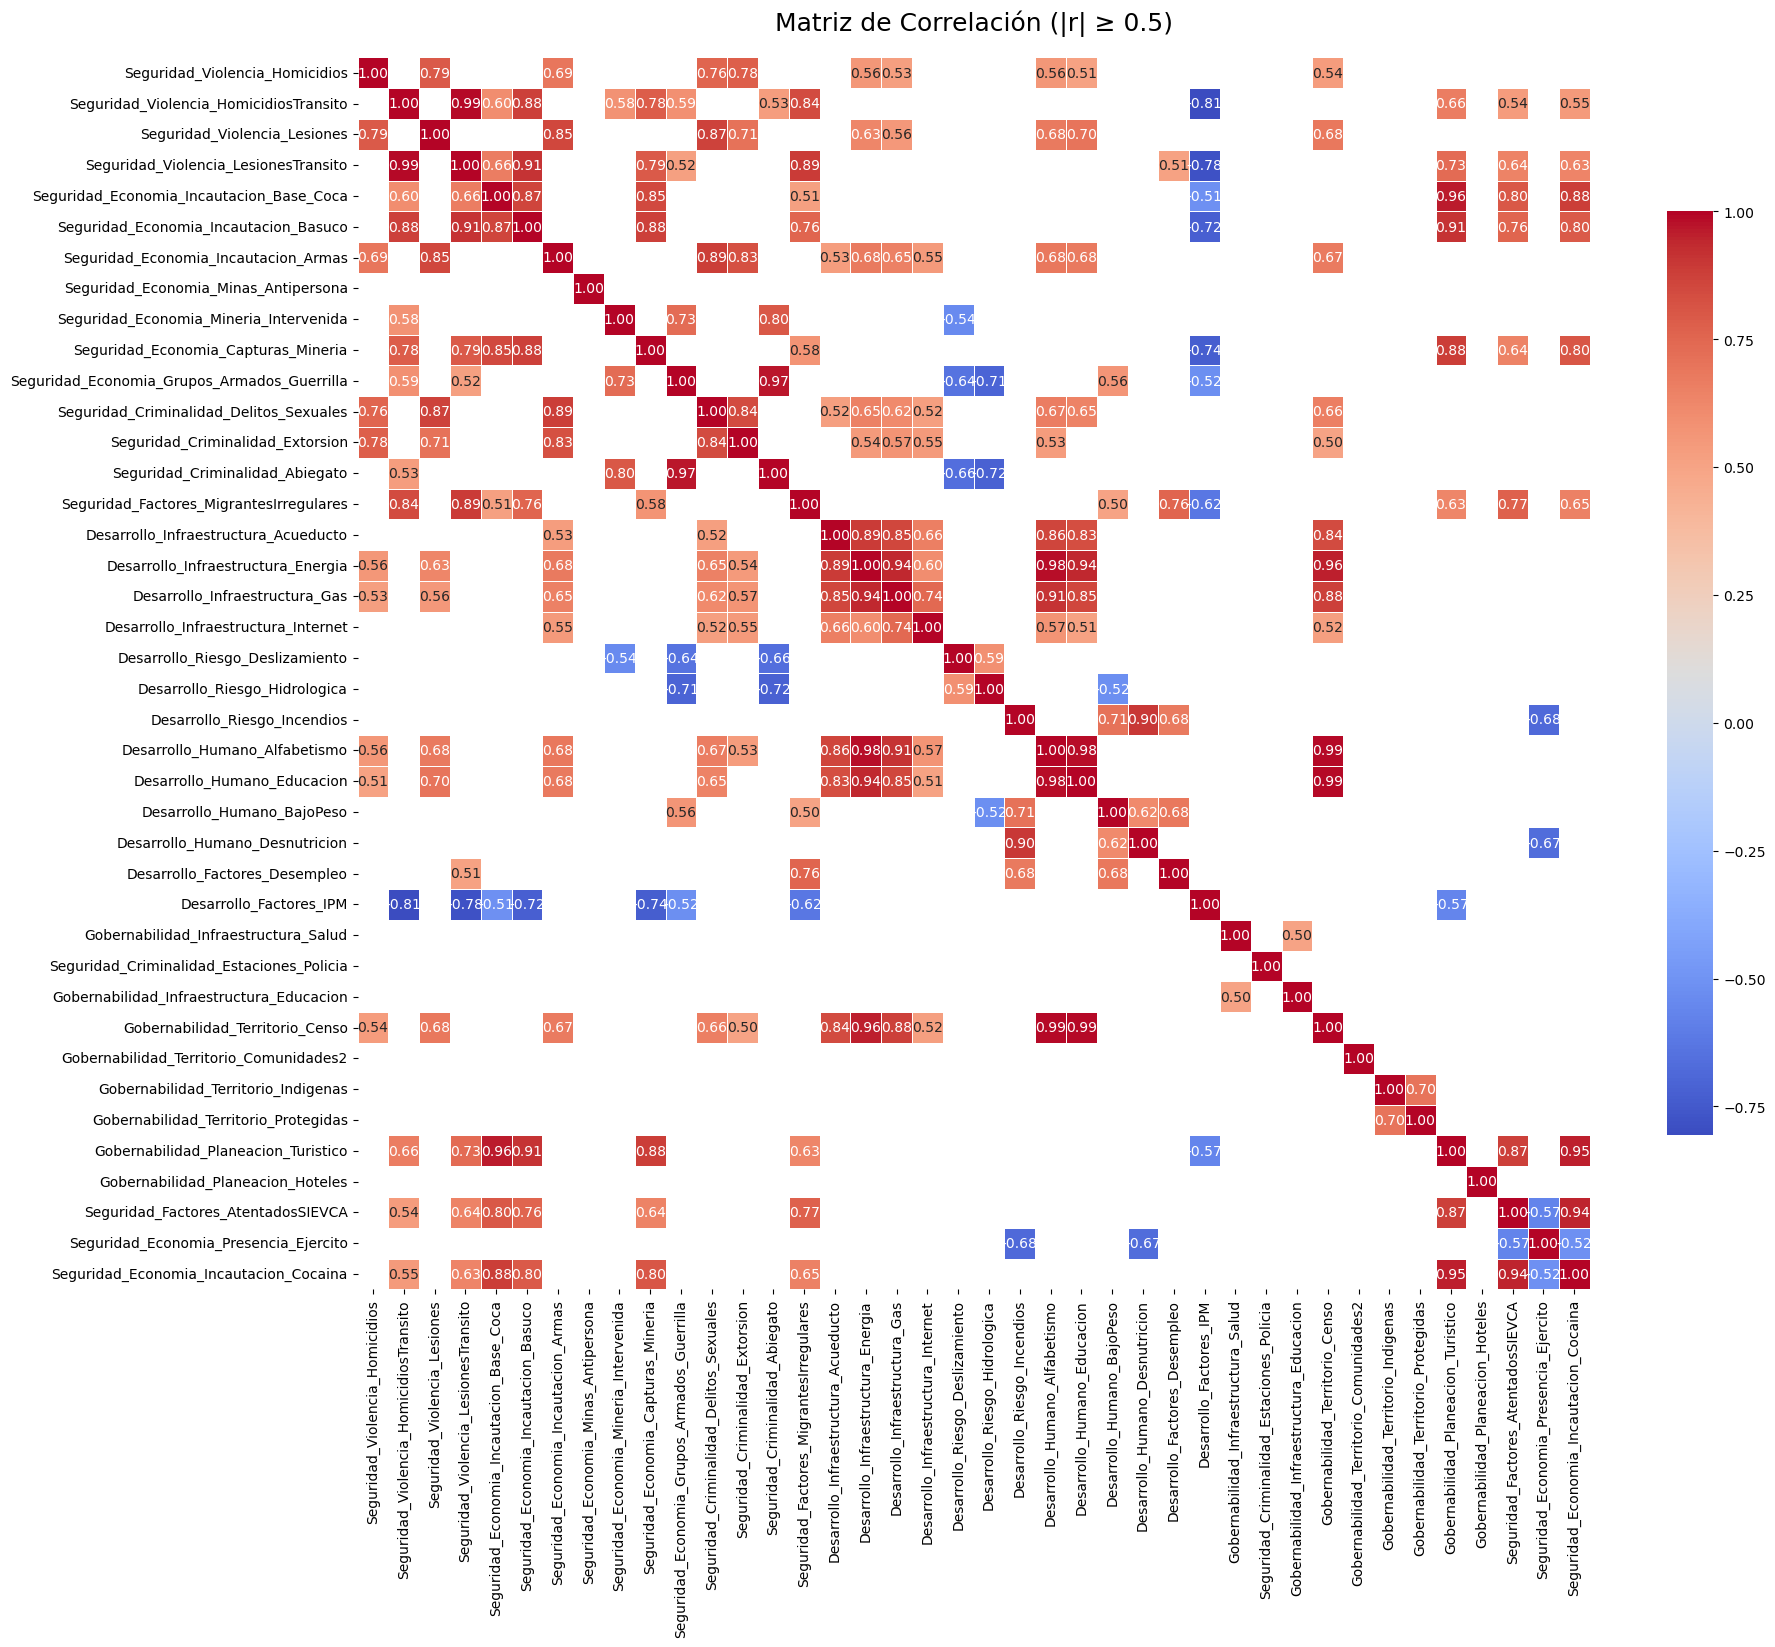

Matriz de correlación filtrada guardada en: C:\Users\Sebastian\Documents\Resultados_EDA\Matriz_Correlacion_Filtrada.png


In [9]:

output_dir = r"C:\Users\Sebastian\Documents\Resultados_EDA"
os.makedirs(output_dir, exist_ok=True)

corr_matrix = df.corr()

filtered_corr = corr_matrix.copy()
filtered_corr[np.abs(filtered_corr) < 0.5] = np.nan  

plt.figure(figsize=(20, 16))
sns.heatmap(filtered_corr, annot=True, fmt=".2f", cmap="coolwarm", square=True,
            linewidths=0.5, cbar_kws={"shrink": .75}, mask=filtered_corr.isnull())

plt.title("Matriz de Correlación (|r| ≥ 0.5)", fontsize=18, pad=20)

output_path = os.path.join(output_dir, "Matriz_Correlacion_Filtrada.png")
plt.savefig(output_path, dpi=200, bbox_inches='tight')
plt.show()

print(f"Matriz de correlación filtrada guardada en: {output_path}")


In [10]:
y = cargar_variable_y(gdb_path, 'EsperanzaVidaDepto', aoi_vector, base_layer)


Variable Y cargada: 1991580 píxeles válidos


In [12]:
gdb_path = r"C:\Users\Sebastian\Documents\CIDENAL\RasterIni.gdb"
exportar_rasters(df, y, gdb_path, base_layer="AreaDelimitadorSierra", prefix="INI")


Exportando: Seguridad_Violencia_Homicidios
Exportando: Seguridad_Violencia_HomicidiosTransito
Exportando: Seguridad_Violencia_Lesiones
Exportando: Seguridad_Violencia_LesionesTransito
Exportando: Seguridad_Economia_Incautacion_Base_Coca
Exportando: Seguridad_Economia_Incautacion_Basuco
Exportando: Seguridad_Economia_Incautacion_Armas
Exportando: Seguridad_Economia_Minas_Antipersona
Exportando: Seguridad_Economia_Mineria_Intervenida
Exportando: Seguridad_Economia_Capturas_Mineria
Exportando: Seguridad_Economia_Grupos_Armados_Guerrilla
Exportando: Seguridad_Criminalidad_Delitos_Sexuales
Exportando: Seguridad_Criminalidad_Extorsion
Exportando: Seguridad_Criminalidad_Abiegato
Exportando: Seguridad_Factores_MigrantesIrregulares
Exportando: Desarrollo_Infraestructura_Acueducto
Exportando: Desarrollo_Infraestructura_Energia
Exportando: Desarrollo_Infraestructura_Gas
Exportando: Desarrollo_Infraestructura_Internet
Exportando: Desarrollo_Riesgo_Deslizamiento
Exportando: Desarrollo_Riesgo_Hidrol

In [13]:
log1p_vars = [
    "Desarrollo_Humano_Alfabetismo", "Desarrollo_Humano_Educacion",
    "Desarrollo_Infraestructura_Acueducto", "Desarrollo_Infraestructura_Energia",
    "Desarrollo_Infraestructura_Gas", "Desarrollo_Infraestructura_Internet",
    "Gobernabilidad_Planeacion_Turistico", "Gobernabilidad_Territorio_Censo",
    
    "Seguridad_Economia_Incautacion_Armas", "Seguridad_Economia_Incautacion_Base_Coca",
    "Seguridad_Economia_Incautacion_Basuco", "Seguridad_Criminalidad_Abiegato",
    "Seguridad_Criminalidad_Delitos_Sexuales", "Seguridad_Criminalidad_Extorsion",
    "Seguridad_Economia_Capturas_Mineria", "Seguridad_Factores_MigrantesIrregulares",
    "Seguridad_Violencia_Homicidios", "Seguridad_Violencia_HomicidiosTransito",
    "Seguridad_Violencia_Lesiones", "Seguridad_Violencia_LesionesTransito",
    "Seguridad_Economia_Incautacion_Cocaina"
]

zscore_vars = [
    "Desarrollo_Factores_Desempleo", "Desarrollo_Factores_IPM",
    "Desarrollo_Humano_BajoPeso", "Desarrollo_Humano_Desnutricion"
]


no_change_vars = [
    "Desarrollo_Riesgo_Incendios", "Gobernabilidad_Infraestructura_Educacion",
    "Gobernabilidad_Infraestructura_Salud", "Gobernabilidad_Planeacion_Hoteles",
    "Gobernabilidad_Territorio_Indigenas", "Seguridad_Criminalidad_Estaciones_Policia",
    "Seguridad_Factores_AtentadosSIEVCA", "Gobernabilidad_Territorio_Protegidas",
    "Seguridad_Economia_Mineria_Intervenida", "Desarrollo_Riesgo_Hidrologica",
    "Desarrollo_Riesgo_Incendios", "Desarrollo_Riesgo_Deslizamiento",
    "Seguridad_Economia_Grupos_Armados_Guerrilla", "Seguridad_Economia_Minas_Antipersona",
    "Gobernabilidad_Territorio_Comunidades", "Seguridad_Economia_Presencia_Ejercito"
]

df_t = df.copy()



In [14]:
# === 3. TRANSFORMACIÓN log1p() ==============================================

df_t[log1p_vars] = df_t[log1p_vars].clip(lower=0)
df_t[log1p_vars] = np.log1p(df_t[log1p_vars])

# === 4. ESCALADO Z-SCORE =====================================================
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_t[zscore_vars] = scaler.fit_transform(df_t[zscore_vars])




In [15]:
gdb_path = r"C:\Users\Sebastian\Documents\CIDENAL\RasterTransformed.gdb"

exportar_rasters(df_t, y, gdb_path, base_layer="AreaDelimitadorSierra", prefix="transformed")


Exportando: Seguridad_Violencia_Homicidios
Exportando: Seguridad_Violencia_HomicidiosTransito
Exportando: Seguridad_Violencia_Lesiones
Exportando: Seguridad_Violencia_LesionesTransito
Exportando: Seguridad_Economia_Incautacion_Base_Coca
Exportando: Seguridad_Economia_Incautacion_Basuco
Exportando: Seguridad_Economia_Incautacion_Armas
Exportando: Seguridad_Economia_Minas_Antipersona
Exportando: Seguridad_Economia_Mineria_Intervenida
Exportando: Seguridad_Economia_Capturas_Mineria
Exportando: Seguridad_Economia_Grupos_Armados_Guerrilla
Exportando: Seguridad_Criminalidad_Delitos_Sexuales
Exportando: Seguridad_Criminalidad_Extorsion
Exportando: Seguridad_Criminalidad_Abiegato
Exportando: Seguridad_Factores_MigrantesIrregulares
Exportando: Desarrollo_Infraestructura_Acueducto
Exportando: Desarrollo_Infraestructura_Energia
Exportando: Desarrollo_Infraestructura_Gas
Exportando: Desarrollo_Infraestructura_Internet
Exportando: Desarrollo_Riesgo_Deslizamiento
Exportando: Desarrollo_Riesgo_Hidrol